# IV.1 — Résultats : RSV (France) — ODiSSEE & ERVISS

**Figures principales**  
- **Fig. 1A** — ODiSSEE France : urgences / SOS / hospitalisations (hebdo, jalons COVID)  
- **Fig. 1B-1** — ERVISS : % positivité (≈2016→…)  
- **Fig. 1B-2** — ERVISS : % positivité (gauche) + indicateur long & tests (droite, normalisés 0–100)  
- **Fig. 2** — Heatmaps saisonnières (z-score) : ODiSSEE (hosp) vs ERVISS (indic. choisi)  
- **Fig. R3(A)** — Pic régional : (A) heatmap “semaine ISO du pic” par saison ; (B) barre exemple 2021/2022  
- **Fig. 3** — Δ (semaine du pic) vs baseline 2019/2020 (ODiSSEE)  
- **Fig. 4** — ERVISS par âge : détections (z-score)  
- **Encart (1B-2)** — Robustesse “détections ≠ simple artefact de tests” (mini-panel)  

**Annexe (lisibilité D5)**  
- **D5-ECDF** — CDF cumulative de la “semaine du pic” par saison (départements)  
- **D5-Strip (option)** — “Strip” 2021 par département (zoom lisible)

Les cellules ci-dessous chargent les données, construisent les figures, et exportent **PNG + PDF** pour insertion dans le manuscrit.


In [1]:
# -*- coding: utf-8 -*-
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import spearmanr

# Dossiers & chemins (robustes)
DATA_ROOTS = [Path("../data_clean")]
def first_existing(*rel_parts):
    for root in DATA_ROOTS:
        p = root.joinpath(*rel_parts)
        if p.exists():
            return p
    return None

FR_ODISSEE = first_existing("ODISSEE", "common_FR_long.csv")
FR_REG     = first_existing("ODISSEE", "common_REG_long.csv")
FR_DEP     = first_existing("ODISSEE", "common_DEP_long.csv")
FR_ERVISS  = first_existing("ERVISS",  "erviss_fr_weekly.csv")
ERVISS_AGE = first_existing("ERVISS",  "erviss_fr_weekly_by_age.csv")

assert FR_ODISSEE is not None, "ODiSSEE FR introuvable"
assert FR_ERVISS  is not None, "ERVISS FR introuvable"

OUT = Path("../outputs/IV1_results"); OUT.mkdir(parents=True, exist_ok=True)

# Jalons COVID (France)
COVID_EVENTS = [
    ("2020-03-16", "Confinement #1"),
    ("2020-10-30", "Confinement #2"),
    ("2020-12-27", "Début vaccination"),
    ("2021-06-15", "Levées majeures"),
]


In [2]:
def read_csv_dates(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    for c in ["date_monday","date","week_start","week_end"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    # harmonisation ISO si déjà présents
    for c in ["year_iso","week_iso_num"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def add_iso_week_label(df: pd.DataFrame, date_col="date_monday", out_col="iso_week_label"):
    iso = df[date_col].dt.isocalendar()
    df[out_col] = iso.apply(lambda r: f"{int(r.year)}-S{int(r.week):02d}", axis=1)
    return df

def covid_shapes_annots(ymax):
    shapes, annots = [], []
    for d, label in COVID_EVENTS:
        shapes.append(dict(type="line", xref="x", yref="paper", x0=d, x1=d, y0=0, y1=1,
                           line=dict(width=1, dash="dot")))
        annots.append(dict(x=d, y=ymax, xref="x", yref="y", text=label,
                           showarrow=False))
    return shapes, annots

def minmax_0_100(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(lo) or pd.isna(hi) or hi <= lo:
        return s*0
    return (s - lo) / (hi - lo) * 100.0

def season_start_monday(y: int) -> pd.Timestamp:
    july1 = pd.Timestamp(year=int(y), month=7, day=1)
    return july1 - pd.Timedelta(days=july1.weekday())  # lundi de la semaine contenant le 1er juillet

def add_season_grid(df: pd.DataFrame, date_col="date_monday"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col])
    year = d[date_col].dt.year
    month = d[date_col].dt.month
    d["season_start_year"] = np.where(month >= 7, year, year - 1).astype(int)
    d["season_start_monday"] = d["season_start_year"].apply(season_start_monday)
    d["season_week"] = ((d[date_col] - d["season_start_monday"]).dt.days // 7 + 1).astype(int)
    d["season_label"] = d["season_start_year"].astype(str) + "/" + (d["season_start_year"]+1).astype(str)
    return d

def zscore_by_season(df, value_col, season_col="season_label"):
    out = df.copy()
    out["_mu"] = out.groupby(season_col)[value_col].transform("mean")
    out["_sd"] = out.groupby(season_col)[value_col].transform("std")
    out[value_col + "_z"] = (out[value_col] - out["_mu"]) / out["_sd"]
    return out.drop(columns=["_mu","_sd"])


In [3]:
# Lecture
fr = read_csv_dates(FR_ODISSEE)

# Filtre RSV France
mask_fr = (fr["topic"].astype(str)=="RSV")
if "geo_level" in fr.columns:
    mask_fr &= fr["geo_level"].astype(str).str.upper().eq("FR")
rsv_fr = fr.loc[mask_fr].copy().dropna(subset=["date_monday"])

# Métriques disponibles
all_metric_candidates = ["taux_passages_urgences","taux_sos","taux_hosp",
                         "taux_hospitalisations","taux_hospitalisation"]
# on mappe les alias hosp -> taux_hosp
alias_map = {"taux_hospitalisations":"taux_hosp", "taux_hospitalisation":"taux_hosp"}
for old,new in alias_map.items():
    if old in rsv_fr.columns and new not in rsv_fr.columns:
        rsv_fr[new] = rsv_fr[old]

metrics = [m for m in ["taux_passages_urgences","taux_sos","taux_hosp"] if m in rsv_fr.columns]
assert len(metrics) >= 1, f"Aucune des métriques attendues n'est dispo: {all_metric_candidates}"

# Séries hebdo lissées (moyenne si doublons)
rsv_fr = rsv_fr.groupby("date_monday", as_index=False)[metrics].mean(numeric_only=True)
rsv_fr = add_season_grid(rsv_fr, "date_monday")

# borne saisons 2018 → 2025
rsv_fr = rsv_fr[(rsv_fr["season_start_year"]>=2018) & (rsv_fr["season_start_year"]<=2024)].copy()

# Table des pics par saison
def season_peak_row(g, value_col):
    g2 = g.dropna(subset=[value_col])
    if g2.empty:
        return pd.Series({"peak_date": pd.NaT, "peak_season_week": np.nan, "peak_value": np.nan})
    idx = g2[value_col].idxmax()
    return pd.Series({
        "peak_date": g2.loc[idx, "date_monday"],
        "peak_season_week": int(g2.loc[idx, "season_week"]),
        "peak_value": float(g2.loc[idx, value_col])
    })

# Choix métrique pivot pour la Table des pics (urgences prioritaire)
metric_pivot = metrics[0]
if "taux_passages_urgences" in metrics:
    metric_pivot = "taux_passages_urgences"

peaks_fr = (
    rsv_fr.groupby("season_label", as_index=False)
          .apply(lambda g: season_peak_row(g, metric_pivot))
          .reset_index(drop=True)
          .sort_values("season_label")
)

# Baseline = première saison pré-COVID existante (<= 2019/2020)
def pick_baseline_label(seasons: pd.Series) -> str:
    ss = pd.Series(pd.Index(seasons).unique()).dropna().astype(str)
    starts = ss.str.split("/", n=1).str[0].astype(int)
    pre = ss[starts <= 2019]
    return pre.min() if not pre.empty else ss.min()

baseline_label = pick_baseline_label(peaks_fr["season_label"])
baseline_week  = int(peaks_fr.loc[peaks_fr["season_label"]==baseline_label, "peak_season_week"].iloc[0])
peaks_fr["Δpeak_weeks"] = peaks_fr["peak_season_week"] - baseline_week

# Export & aperçu
peaks_fr.to_csv(OUT / "peaks_FR_ODISSEE.csv", index=False)
display(peaks_fr)
print("Baseline:", baseline_label, "→ semaine", baseline_week)
print("CSV:", OUT / "peaks_FR_ODISSEE.csv")


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/1689989977.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: season_peak_row(g, metric_pivot))


,season_label,peak_date,peak_season_week,peak_value,Δpeak_weeks
0,2019/2020,2019-12-30,27,1763.343846,0
1,2020/2021,2021-03-29,40,1232.817456,13
2,2021/2022,2021-11-29,23,1944.638986,-4
3,2022/2023,2022-11-21,22,2861.524018,-5
4,2023/2024,2023-11-27,23,2398.321695,-4
5,2024/2025,2024-12-09,24,1563.269147,-3


Baseline: 2019/2020 → semaine 27
CSV: ../outputs/IV1_results/peaks_FR_ODISSEE.csv


### Figure 1A — RSV (France, ODiSSEE) : urgences / SOS / hospitalisations

Trois séries hebdomadaires (lundi ISO) pour la France entière, avec **jalons COVID** en lignes pointillées verticales.  
Cette figure sert d’ossature descriptive : trou 2020–2021, rebond décalé 2021, précocité 2022, ré-alignement progressif 2023–2025.

In [4]:
name_map = {
    "taux_passages_urgences": "RSV — urgences (taux)",
    "taux_sos": "RSV — SOS Médecins (taux)",
    "taux_hosp": "RSV — hospitalisations (taux)",
}
color_map = {
    "taux_passages_urgences": "#1f77b4",
    "taux_sos": "#ff7f0e",
    "taux_hosp": "#2ca02c",
}

fig1a = go.Figure()
for met in metrics:
    fig1a.add_trace(go.Scatter(
        x=rsv_fr["date_monday"], y=rsv_fr[met],
        mode="lines", name=name_map.get(met, met),
        line=dict(color=color_map.get(met, "gray"), width=2.2)
    ))

ymax = float(np.nanmax(rsv_fr[metrics].values))
shapes, annots = covid_shapes_annots(ymax)
for ann in annots:
    ann["textangle"] = -90
    ann["y"] = ymax * 1.02
    ann["xanchor"] = "left"
    ann["yanchor"] = "bottom"
    ann["showarrow"] = False
    if isinstance(ann.get("text"), str) and not ann["text"].startswith("<i>"):
        ann["text"] = f"<i>{ann['text']}</i>"
    ann["font"] = dict(size=12, color="black")

xaxis_common = dict(
    title="Date (semaine ISO, lundi)",
    tickformat="%b %Y", tickangle=-30,
    showgrid=True, gridcolor="lightgray",
    zeroline=False
)
yaxis_common = dict(
    title="Taux pour 100 000 passages / consultations",
    showgrid=True, gridcolor="lightgray",
    zeroline=False
)

fig1a.update_layout(
    shapes=shapes, annotations=annots,
    xaxis=xaxis_common, yaxis=yaxis_common,
    title=dict(text="Figure 1A — RSV (France, ODiSSEE) : urgences / SOS / hospitalisations", x=0.01),
    margin=dict(l=70, r=20, t=60, b=80),
    font=dict(size=14, family="Arial"),
    legend=dict(orientation="h", y=-0.28, x=0.5, xanchor="center", yanchor="top")
)
fig1a.show()

# Export
try:
    fig1a.write_image(OUT / "Fig1A_ODISSEE_FR_urgences_SOS_hosp.png", scale=2)
    fig1a.write_image(OUT / "Fig1A_ODISSEE_FR_urgences_SOS_hosp.pdf")
except Exception as e:
    print("Export Fig.1A échoué (kaleido ?):", e)


In [5]:
erv = read_csv_dates(FR_ERVISS)

# Filtre RSV
if "pathogen" in erv.columns:
    erv = erv[erv["pathogen"].astype(str).str.contains("RSV", case=False, na=False)].copy()

# Colonne date
date_col = "date_monday" if "date_monday" in erv.columns else ("date" if "date" in erv.columns else None)
assert date_col is not None, "ERVISS: 'date_monday' ou 'date' requis"

erv = erv.dropna(subset=[date_col, "value"]).copy()
erv[date_col] = pd.to_datetime(erv[date_col], errors="coerce")

# Choix indicateur long (≠ positivity) : le plus ancien / le plus fourni
if "indicator" in erv.columns:
    span = (erv.groupby("indicator")[date_col]
              .agg(min_date="min", max_date="max", n="count")
              .reset_index()
              .sort_values(["min_date","n"], ascending=[True, False]))
    # positif prioritaire pour ser_pos
    has_pos = (erv["indicator"].str.lower()=="positivity").any()
    long_cand = span[span["indicator"].str.lower()!="positivity"]
    long_ind = long_cand.iloc[0]["indicator"] if not long_cand.empty else None
else:
    # format large : pas d'indicator
    has_pos = False; long_ind = None

def prep_series(df, indicator_name, date_col="date_monday", agg="mean"):
    if "indicator" in df.columns:
        s = df[df["indicator"].str.lower()==indicator_name.lower()].copy()
    else:
        s = df.copy()
    if s.empty:
        return pd.DataFrame(columns=[date_col,"value","iso_week_label"])
    if agg == "mean":
        s = s.groupby(date_col, as_index=False)["value"].mean(numeric_only=True)
    elif agg == "sum":
        s = s.groupby(date_col, as_index=False)["value"].sum(numeric_only=True)
    s = s.sort_values(date_col).dropna(subset=[date_col,"value"]).copy()
    s = add_iso_week_label(s, date_col, "iso_week_label")
    return s

ser_pos  = prep_series(erv, "positivity", date_col=date_col) if has_pos else pd.DataFrame(columns=[date_col,"value","iso_week_label"])
ser_long = prep_series(erv, long_ind,      date_col=date_col) if long_ind else pd.DataFrame(columns=[date_col,"value","iso_week_label"])

# Tests : colonne dédiée ("tests"/"n_tests") OU indicator=="tests"
tests_candidates = [c for c in ["tests","n_tests","nb_tests"] if c in erv.columns]
if tests_candidates:
    ser_tests = prep_series(erv.rename(columns={tests_candidates[0]:"value"}), tests_candidates[0], date_col=date_col)
elif "indicator" in erv.columns and (erv["indicator"].str.lower()=="tests").any():
    ser_tests = prep_series(erv, "tests", date_col=date_col)
else:
    ser_tests = pd.DataFrame(columns=[date_col,"value","iso_week_label"])

print("long_ind choisi pour 1B-2:", long_ind)


long_ind choisi pour 1B-2: detections


### Figure 1B-1 — ERVISS (RSV) : % positivité

Série hebdomadaire (≈2016→…) permettant de contextualiser le **pré-pandémique** : pics hivernaux regroupés, effondrement 2020–21,
ré-émergence hors hiver (printemps 2021) puis précocité en 2022.


In [6]:
fig1b_pos = go.Figure()
if not ser_pos.empty:
    fig1b_pos.add_trace(go.Scatter(
        x=ser_pos[date_col], y=ser_pos["value"], mode="lines",
        name="% positivité (ERVISS)", line=dict(width=2.2)
    ))
    ymax_b = float(np.nanmax(ser_pos["value"]))
else:
    ymax_b = 100.0
    fig1b_pos.add_annotation(text="⚠️ 'positivity' indisponible",
        xref="paper", yref="paper", x=0.02, y=0.95, showarrow=False, font=dict(color="red"))

shapes, annots = covid_shapes_annots(ymax_b)
for ann in annots:
    ann["textangle"]=-90; ann["y"]=ymax_b*1.02; ann["xanchor"]="left"; ann["yanchor"]="bottom"; ann["showarrow"]=False

fig1b_pos.update_layout(
    shapes=shapes, annotations=annots,
    xaxis=dict(title="Date (semaine ISO, lundi)", tickformat="%b %Y", tickangle=-30,
               showgrid=True, gridcolor="lightgray", zeroline=False),
    yaxis=dict(title="% positivité (ERVISS)", rangemode="tozero",
               showgrid=True, gridcolor="lightgray", zeroline=False),
    title=dict(text="Figure 1B-1 — ERVISS (RSV) : % positivité", x=0.01),
    margin=dict(l=70, r=20, t=60, b=80),
    legend=dict(orientation="h", y=-0.28, x=0.5, xanchor="center")
)
fig1b_pos.show()

try:
    fig1b_pos.write_image(OUT / "Fig1B1_ERVISS_positivity.png", scale=2)
    fig1b_pos.write_image(OUT / "Fig1B1_ERVISS_positivity.pdf")
except Exception as e:
    print("Export Fig.1B-1 échoué:", e)


### Figure 1B-2 — ERVISS (RSV) : % positivité (axe gauche) vs indicateur long + tests (axe droit, 0–100)

Axe gauche : **% positivité** ; Axe droit : **indicateur long** (ex. *detections*) **et** **tests**, tous deux **normalisés (0–100)**.  
**Légende placée sous le graphe**. Cette mise en parallèle vérifie que les variations de détection ne se réduisent pas au seul volume de tests.

In [7]:
fig1b_dual = go.Figure()

# gauche
if not ser_pos.empty:
    fig1b_dual.add_trace(go.Scatter(
        x=ser_pos[date_col], y=ser_pos["value"],
        mode="lines", name="% positivité (gauche)", yaxis="y1", line=dict(width=2.0)
    ))
    ymax_left = float(np.nanmax(ser_pos["value"]))
else:
    ymax_left = 100.0

# droite — long
right_traces = []
if not ser_long.empty:
    y_long_norm = minmax_0_100(ser_long["value"])
    fig1b_dual.add_trace(go.Scatter(
        x=ser_long[date_col], y=y_long_norm,
        mode="lines", name=f"{long_ind} (droite, 0–100)", yaxis="y2"
    ))
    right_traces.append(long_ind)

# droite — tests
if not ser_tests.empty:
    y_tests_norm = minmax_0_100(ser_tests["value"])
    fig1b_dual.add_trace(go.Scatter(
        x=ser_tests[date_col], y=y_tests_norm,
        mode="lines", name="tests (droite, 0–100)", yaxis="y2", line=dict(dash="dot")
    ))
    right_traces.append("tests")

y2_title = " / ".join(right_traces) + " (0–100)" if right_traces else "Axe droit (0–100)"

shapes2, annots2 = covid_shapes_annots(ymax_left)
for ann in annots2:
    ann["textangle"]=-90; ann["y"]=ymax_left*1.02; ann["xanchor"]="left"; ann["yanchor"]="bottom"; ann["showarrow"]=False

fig1b_dual.update_layout(
    xaxis=dict(title="Date (semaine ISO, lundi)", tickformat="%b %Y", tickangle=-30,
               showgrid=True, gridcolor="lightgray", zeroline=False),
    yaxis=dict(title="% positivité", rangemode="tozero",
               showgrid=True, gridcolor="lightgray", zeroline=False),
    yaxis2=dict(title=y2_title, overlaying="y", side="right"),
    title=dict(text="Figure 1B-2 — ERVISS (RSV) : % positivité vs indicateur long + tests (0–100)", x=0.01),
    margin=dict(l=80, r=80, t=60, b=90),
    hovermode="x unified",
    shapes=shapes2, annotations=annots2,
    legend=dict(orientation="h", y=-0.32, x=0.5, xanchor="center")  # légende dessous
)
fig1b_dual.show()

try:
    fig1b_dual.write_image(OUT / "Fig1B2_ERVISS_dual_pos_long_tests.png", scale=2)
    fig1b_dual.write_image(OUT / "Fig1B2_ERVISS_dual_pos_long_tests.pdf")
except Exception as e:
    print("Export Fig.1B-2 échoué:", e)


#### Encart — vérification “détections ≠ simple artefact de tests”
Comparaison **détections (0–100)** vs **tests (0–100)** et **% positivité**.  
Si les détections augmentent **au-delà** de ce qu’expliquerait le volume de tests, la structure saisonnière reflète une **vraie intensification** de la circulation (et non un artefact d’offre de tests).

In [8]:
# Fusion
to_merge = []
if not ser_long.empty:
    _long = ser_long[[date_col, "value"]].rename(columns={"value":"detections"})
    _long["detections_norm"] = minmax_0_100(_long["detections"])
    to_merge.append(_long[[date_col,"detections_norm"]])

if not ser_tests.empty:
    _tests = ser_tests[[date_col, "value"]].rename(columns={"value":"tests"})
    _tests["tests_norm"] = minmax_0_100(_tests["tests"])
    to_merge.append(_tests[[date_col,"tests_norm"]])

if not ser_pos.empty:
    _pos = ser_pos[[date_col, "value"]].rename(columns={"value":"positivity"})
    to_merge.append(_pos)

enc = None
for part in to_merge:
    enc = part if enc is None else enc.merge(part, on=date_col, how="outer")
enc = enc.sort_values(date_col).dropna(how="all")

# Scatter tests vs detections (norm.)
if enc is not None and {"tests_norm","detections_norm"}.issubset(enc.columns):
    ok = enc[["tests_norm","detections_norm"]].dropna()
    r = spearmanr(ok["tests_norm"], ok["detections_norm"]).correlation if len(ok)>3 else np.nan
    fig_encart = go.Figure()
    fig_encart.add_trace(go.Scatter(x=ok["tests_norm"], y=ok["detections_norm"],
                                    mode="markers", name="semaines", marker=dict(size=5, opacity=0.7)))
    if len(ok) > 2:
        m = np.polyfit(ok["tests_norm"], ok["detections_norm"], 1)
        xx = np.linspace(ok["tests_norm"].min(), ok["tests_norm"].max(), 50)
        fig_encart.add_trace(go.Scatter(x=xx, y=m[0]*xx+m[1], mode="lines", name="tendance"))
    fig_encart.update_layout(
        title=f"Encart — détections (0–100) vs tests (0–100)  •  Spearman r≈{r:.2f}",
        xaxis=dict(title="Tests (0–100)"), yaxis=dict(title="Détections (0–100)"),
        width=520, height=420, margin=dict(l=60, r=20, t=60, b=60),
        legend=dict(orientation="h", y=-0.3, x=0.5, xanchor="center")
    )
    fig_encart.show()
    try:
        fig_encart.write_image(OUT / "Encart_tests_vs_detections.png", scale=2)
        fig_encart.write_image(OUT / "Encart_tests_vs_detections.pdf")
    except Exception as e:
        print("Export encart scatter échoué:", e)

# Courbes mini : positivity vs tests
if enc is not None and "positivity" in enc.columns and "tests_norm" in enc.columns:
    fig_encart2 = go.Figure()
    fig_encart2.add_trace(go.Scatter(x=enc[date_col], y=enc["positivity"], mode="lines", name="% positivité"))
    fig_encart2.add_trace(go.Scatter(x=enc[date_col], y=enc["tests_norm"], mode="lines", name="tests (0–100)",
                                     yaxis="y2", line=dict(dash="dot")))
    fig_encart2.update_layout(
        title="Encart — % positivité (gauche) vs tests (droite, 0–100)",
        xaxis=dict(title="Date (lundi ISO)"),
        yaxis=dict(title="% positivité"),
        yaxis2=dict(title="tests (0–100)", overlaying="y", side="right"),
        width=700, height=380, margin=dict(l=80, r=80, t=60, b=60),
        legend=dict(orientation="h", y=-0.28, x=0.5, xanchor="center")
    )
    fig_encart2.show()
    try:
        fig_encart2.write_image(OUT / "Encart_pos_vs_tests.png", scale=2)
        fig_encart2.write_image(OUT / "Encart_pos_vs_tests.pdf")
    except Exception as e:
        print("Export encart lignes échoué:", e)


### Figure 2 — Heatmaps saisonnières alignées (z-score) : ODiSSEE (hosp) × ERVISS (indic. choisi)

Saisons **juillet→juin**, *z-score par saison* pour comparer les **dynamiques** (échelles neutralisées).  
Deux panneaux superposés : **ODiSSEE (hosp)** et **ERVISS** (positivity si dispo, sinon indicateur le plus ancien).


In [9]:
# Choix hosp_col pour ODiSSEE
hosp_col = "taux_hosp" if "taux_hosp" in rsv_fr.columns else (
    "taux_passages_urgences" if "taux_passages_urgences" in rsv_fr.columns else metrics[0]
)

# ODiSSEE (hosp) → z par saison
rsv_hosp = rsv_fr[["date_monday", hosp_col]].dropna()
rsv_hosp = add_season_grid(rsv_hosp, "date_monday")
rsv_hosp = rsv_hosp[(rsv_hosp["season_start_year"]>=2018)&(rsv_hosp["season_start_year"]<=2024)].copy()
rsv_hosp_z = zscore_by_season(rsv_hosp, hosp_col, "season_label")

# ERVISS indicateur pour la heatmap (positivity prioritaire)
indic_name = "positivity" if not ser_pos.empty else (long_ind if long_ind else "value")
erv_sel = ser_pos.rename(columns={"value":"value"}).copy() if indic_name=="positivity" else ser_long.rename(columns={"value":"value"}).copy()
erv_sel = erv_sel[[date_col,"value"]].rename(columns={date_col:"date_monday"}).dropna()
erv_sel = add_season_grid(erv_sel, "date_monday")
erv_sel = erv_sel[(erv_sel["season_start_year"]>=2018)&(erv_sel["season_start_year"]<=2024)].copy()
erv_sel_z = zscore_by_season(erv_sel, "value", "season_label")

def season_pivot(df, value_col):
    pv = df.pivot_table(index="season_label", columns="season_week", values=value_col, aggfunc="mean")
    return pv.sort_index()

pv_hosp = season_pivot(rsv_hosp_z, hosp_col + "_z")
pv_erv  = season_pivot(erv_sel_z,   "value_z")

def heatmap_from_pivot(pv, title, cbar_title):
    return go.Heatmap(
        z=pv.values, x=pv.columns, y=pv.index,
        colorscale="RdBu_r", colorbar=dict(title=cbar_title),
        hovertemplate="Saison: %{y}<br>Sem. saison: %{x}<br>z: %{z:.2f}<extra></extra>"
    )

fig2 = make_subplots(rows=2, cols=1, shared_xaxes=False, shared_yaxes=True,
                     vertical_spacing=0.08,
                     subplot_titles=(f"ODiSSEE — {hosp_col} (z-score/saison)",
                                     f"ERVISS — {indic_name} (z-score/saison)"))

fig2.add_trace(heatmap_from_pivot(pv_hosp, "", "z-ODiSSEE"), row=1, col=1)
fig2.add_trace(heatmap_from_pivot(pv_erv,  "", "z-ERVISS"),  row=2, col=1)

fig2.update_yaxes(autorange="reversed", title_text="Saison", row=1, col=1)
fig2.update_yaxes(autorange="reversed", title_text="Saison", row=2, col=1)
fig2.update_xaxes(title_text="Semaine de saison (1–52/53)", row=1, col=1)
fig2.update_xaxes(title_text="Semaine de saison (1–52/53)", row=2, col=1)

fig2.update_layout(
    title="Figure 2 — Heatmaps saisonnières : ODiSSEE (hosp) × ERVISS",
    margin=dict(l=80, r=20, t=80, b=60),
    height=760
)
fig2.show()

try:
    fig2.write_image(OUT / "Fig2_heatmaps_saisons_ODISSEE_vs_ERVISS.png", scale=2)
    fig2.write_image(OUT / "Fig2_heatmaps_saisons_ODISSEE_vs_ERVISS.pdf")
except Exception as e:
    print("Export Fig.2 échoué:", e)


### Figure R3(A) — Semaine ISO du **pic** par région et par saison

(A) **Heatmap** (région × saison) de la **semaine ISO du pic** (ODiSSEE).  
(B) **Barres** pour une saison exemple (par défaut **2021/2022**), lisible en annexe si besoin.

In [10]:
assert FR_REG is not None, "Fichier régional ODiSSEE manquant"
reg = read_csv_dates(FR_REG)
mask_reg = (reg["topic"].astype(str)=="RSV") & (reg["geo_level"].astype(str).str.upper().isin(["REG","REGION","NREG"]))
rsv_reg = reg.loc[mask_reg].copy()

# métrique: hosp si dispo sinon urgences
metric_reg = "taux_hosp" if "taux_hosp" in rsv_reg.columns else (
    "taux_passages_urgences" if "taux_passages_urgences" in rsv_reg.columns else None
)
assert metric_reg is not None, "Aucune métrique RSV trouvée au niveau régional"

tmp_reg = add_season_grid(rsv_reg.dropna(subset=["date_monday", metric_reg]), "date_monday")

def peak_row_region(g):
    g2 = g.dropna(subset=[metric_reg])
    if g2.empty:
        return pd.Series({"peak_iso_week": np.nan})
    idx = g2[metric_reg].idxmax()
    d = pd.to_datetime(g2.loc[idx, "date_monday"])
    return pd.Series({"peak_iso_week": int(d.isocalendar().week)})

season_reg = (tmp_reg.groupby(["geo_name","season_label"], as_index=False)
              .apply(peak_row_region).reset_index(drop=True))
season_reg = season_reg[season_reg["season_label"].between("2018/2019","2024/2025")].copy()

# (A) Heatmap région × saison
pv_r = season_reg.pivot_table(index="geo_name", columns="season_label", values="peak_iso_week", aggfunc="mean")
pv_r = pv_r.loc[sorted(pv_r.index), sorted(pv_r.columns)]

fig_R3a = go.Figure(go.Heatmap(
    z=pv_r.values, x=pv_r.columns, y=pv_r.index,
    colorscale="Turbo", colorbar=dict(title="Semaine ISO du pic"),
    hovertemplate="Région: %{y}<br>Saison: %{x}<br>Sem. pic: %{z}<extra></extra>"
))
fig_R3a.update_layout(
    title="Figure R3(A) — Semaine ISO du pic RSV par région et saison (ODiSSEE)",
    xaxis=dict(title="Saison"), yaxis=dict(title="Région", autorange="reversed"),
    margin=dict(l=160, r=30, t=70, b=80), height=900
)
fig_R3a.show()

# (B) Barres — saison exemple
focus_season = "2021/2022"
fig_R3b = px.bar(
    season_reg[season_reg["season_label"]==focus_season],
    x="geo_name", y="peak_iso_week",
    labels={"geo_name":"Région","peak_iso_week":"Semaine ISO du pic"},
    title=f"Figure R3(B) — Semaine du pic par région ({focus_season})"
)
fig_R3b.update_layout(xaxis_tickangle=-45, margin=dict(l=160, r=30, t=70, b=120), height=600)
fig_R3b.show()

try:
    fig_R3a.write_image(OUT / "FigR3A_peak_week_region_heatmap.png", scale=2)
    fig_R3a.write_image(OUT / "FigR3A_peak_week_region_heatmap.pdf")
    fig_R3b.write_image(OUT / f"FigR3B_peak_week_region_bar_{focus_season.replace('/','-')}.png", scale=2)
    fig_R3b.write_image(OUT / f"FigR3B_peak_week_region_bar_{focus_season.replace('/','-')}.pdf")
except Exception as e:
    print("Export Fig.R3 échoué:", e)


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2703862360.py:21: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Figure 3 — Δ (semaine du pic) par saison vs baseline 2019/2020

Baseline = **première saison pré-COVID** disponible (ici 2019/2020).  
Barres > 0 = **plus tardif** ; < 0 = **plus précoce**.  
On filtre les saisons **incomplètes** (< 30 semaines observées).

In [11]:
# couverture par saison (nb de semaines observées)
coverage = (rsv_fr.groupby("season_label")["season_week"].nunique()
            .rename("n_weeks_observed").reset_index())
season_tbl = peaks_fr.merge(coverage, on="season_label", how="left")
season_tbl_clean = season_tbl.query("n_weeks_observed >= 30").copy()

df_plot = season_tbl_clean.copy()
df_plot["delta_sign"] = np.where(df_plot["Δpeak_weeks"]>0, "retard (+)",
                         np.where(df_plot["Δpeak_weeks"]<0, "précoce (–)", "aligné (0)"))
color_map = {"retard (+)":"#d62728", "précoce (–)":"#2ca02c", "aligné (0)":"#7f7f7f"}

fig3 = px.bar(
    df_plot, x="season_label", y="Δpeak_weeks", color="delta_sign",
    color_discrete_map=color_map, text="Δpeak_weeks",
    labels={"season_label":"Saison", "Δpeak_weeks":"Décalage du pic (semaines)", "delta_sign":""},
    title=f"Figure 3 — Décalage du pic {metric_pivot} par saison (réf. {baseline_label})"
)
fig3.update_traces(textposition="outside")
fig3.update_layout(
    xaxis=dict(tickangle=-45),
    yaxis=dict(zeroline=True, zerolinecolor="black"),
    margin=dict(l=70, r=20, t=60, b=80),
    legend=dict(orientation="h", y=-0.28, x=0.5, xanchor="center")
)
fig3.add_hline(y=0, line_dash="dot", line_color="black")
fig3.show()

try:
    fig3.write_image(OUT / "Fig3_delta_peak_vs_baseline.png", scale=2)
    fig3.write_image(OUT / "Fig3_delta_peak_vs_baseline.pdf")
except Exception as e:
    print("Export Fig.3 échoué:", e)


### Figure 4 — ERVISS par âge : **détections** (z-score)

Objectif : comparer la **dynamique** par classes d’âge.  
On affiche les **détections** standardisées par âge (z-score), utiles lorsque la % de positivité n’est pas homogène sur toute la période/les âges.

In [12]:
assert ERVISS_AGE is not None, "ERVISS by age introuvable"
erv_age = read_csv_dates(ERVISS_AGE)

# détection robuste colonnes essentielles
date_col_age = "date_monday" if "date_monday" in erv_age.columns else ("date" if "date" in erv_age.columns else None)
assert date_col_age is not None, "ERVISS by age: date manquante"
age_candidates = [c for c in ["age_group","agegroup","age","age_class","age_band","ageband","ageGroup"] if c in erv_age.columns]
if not age_candidates:
    age_candidates = [c for c in erv_age.columns if "age" in c.lower()]
assert age_candidates, "ERVISS by age: aucune colonne d'âge détectée"
age_col = age_candidates[0]

needed = [date_col_age, "indicator", "value", age_col]
assert set(needed).issubset(erv_age.columns), f"Manque colonnes: {set(needed)-set(erv_age.columns)}"

df_age = (erv_age[needed]
          .rename(columns={date_col_age:"date_monday", age_col:"age_group"})
          .dropna(subset=["date_monday","indicator","value","age_group"])
          .copy())
df_age["indicator"] = df_age["indicator"].astype(str)
df_age["age_group"] = df_age["age_group"].astype(str)

# détections si dispo
has_det = (df_age["indicator"].str.lower()=="detections").any()
assert has_det, "L'indicateur 'detections' n'est pas disponible par âge dans ERVISS"
det = df_age[df_age["indicator"].str.lower()=="detections"].copy()

# hebdo par âge
det_w = (det.groupby(["date_monday","age_group"], as_index=False)["value"]
         .mean(numeric_only=True).sort_values(["date_monday","age_group"]))

# z-score par âge
det_w["_mu"] = det_w.groupby("age_group")["value"].transform("mean")
det_w["_sd"] = det_w.groupby("age_group")["value"].transform("std")
det_w["z"] = (det_w["value"] - det_w["_mu"]) / det_w["_sd"]
det_w = det_w.drop(columns=["_mu","_sd"])

# ordre heuristique des âges
def order_ages(values):
    import re
    def key(v):
        s = str(v)
        if s.strip().startswith("<"):
            try: return (-1, int(re.sub(r"\D","",s) or 0), s)
            except: return (-1, 0, s)
        m = re.search(r"(\d+)", s)
        return (int(m.group(1)) if m else 999, s)
    return sorted(pd.Series(values).dropna().unique(), key=key)

age_order = order_ages(det_w["age_group"])

fig4 = px.line(
    det_w, x="date_monday", y="z", color="age_group",
    category_orders={"age_group": age_order},
    labels={"date_monday":"Temps (hebdo, lundi ISO)", "z":"Détections (z-score)", "age_group":"Âge"},
    title="Figure 4 — ERVISS RSV par âge : détections (z-score)"
)
ymax4 = float(det_w["z"].max()) if det_w["z"].notna().any() else 1.0
shapes4, annots4 = covid_shapes_annots(ymax4)
fig4.update_layout(
    shapes=shapes4, annotations=annots4, hovermode="x unified",
    margin=dict(l=70, r=20, t=60, b=80),
    legend=dict(orientation="h", y=-0.28, x=0.5, xanchor="center")
)
fig4.show()

try:
    fig4.write_image(OUT / "Fig4_ERVISS_age_detections_zscore.png", scale=2)
    fig4.write_image(OUT / "Fig4_ERVISS_age_detections_zscore.pdf")
except Exception as e:
    print("Export Fig.4 échoué:", e)


### Figure D5 (Annexe) — Lisibilité des pics **départementaux**
Deux options (garde au moins l’ECDF) :
- **D5-ECDF (recommandé)** : courbe cumulative par saison → lisible et compacte (montre l’étalement vs concentration).
- **D5-Strip 2021 (option)** : strip plot (une année à la fois), zoom très lisible sur l’année perturbée **2021**.

In [13]:
assert FR_DEP is not None, "Données départementales introuvables"
dep = read_csv_dates(FR_DEP)
mask_dep = (dep["topic"].astype(str)=="RSV") & (dep["geo_level"].astype(str).str.upper().isin(["DEP","DEPT","DEPARTEMENT"]))
rsv_dep = dep.loc[mask_dep].copy()

metric_dep = "taux_hosp" if "taux_hosp" in rsv_dep.columns else (
    "taux_passages_urgences" if "taux_passages_urgences" in rsv_dep.columns else None
)
assert metric_dep is not None, "Pas de métrique RSV au niveau départemental"

rsv_dep = rsv_dep.dropna(subset=["date_monday", metric_dep]).copy()
rsv_dep = add_season_grid(rsv_dep, "date_monday")

# peak week ISO par département/saison
def peak_week_dep(g):
    g2 = g.dropna(subset=[metric_dep])
    idx = g2[metric_dep].idxmax()
    d = pd.to_datetime(g2.loc[idx, "date_monday"])
    return pd.Series({"peak_iso_week": int(d.isocalendar().week)})

peaks_dep = (rsv_dep.groupby(["geo_name","season_label"], as_index=False)
             .apply(peak_week_dep).reset_index(drop=True))
peaks_dep = peaks_dep[peaks_dep["season_label"].between("2018/2019","2024/2025")].copy()

# ECDF par saison
figD5_ecdf = go.Figure()
for s in sorted(peaks_dep["season_label"].unique()):
    x = np.sort(peaks_dep.loc[peaks_dep["season_label"]==s, "peak_iso_week"].dropna().values)
    y = np.arange(1, len(x)+1)/len(x)
    figD5_ecdf.add_trace(go.Scatter(x=x, y=y, mode="lines", name=s))

figD5_ecdf.update_layout(
    title="Figure D5-ECDF — CDF de la semaine du pic (départements) par saison",
    xaxis=dict(title="Semaine ISO du pic", range=[1,53], dtick=4),
    yaxis=dict(title="Part cumulée des départements", range=[0,1]),
    width=1100, height=520, margin=dict(l=80, r=30, t=70, b=70),
    legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center")
)
figD5_ecdf.show()

try:
    figD5_ecdf.write_image(OUT / "FigD5_ECDF_dep_peak.png", scale=2)
    figD5_ecdf.write_image(OUT / "FigD5_ECDF_dep_peak.pdf")
except Exception as e:
    print("Export D5-ECDF échoué:", e)


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2693895404.py:22: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [14]:
# Strip par année avec export focus 2021 (option)
tmp = rsv_dep.copy()
tmp["year_iso"] = tmp["date_monday"].dt.isocalendar().year.astype(int)
peaks_year = (tmp.groupby(["geo_name","year_iso"], as_index=False)
              .apply(lambda g: pd.Series({
                  "peak_iso_week": int(pd.to_datetime(g.loc[g[metric_dep].idxmax(), "date_monday"]).isocalendar().week)
              })).reset_index(drop=True))

figD5_strip_slider = px.strip(
    peaks_year, x="peak_iso_week", y="geo_name", orientation="h",
    animation_frame="year_iso",
    labels={"peak_iso_week":"Semaine ISO du pic", "geo_name":"Département", "year_iso":"Année"},
    title="Figure D5-Strip — Semaine du pic par département (slider annuel)"
)
figD5_strip_slider.update_traces(jitter=0, marker=dict(size=5, opacity=0.75))
figD5_strip_slider.update_xaxes(range=[0.5, 53.5], dtick=2)
figD5_strip_slider.update_layout(width=1100, height=950, margin=dict(l=180, r=40, t=70, b=60))
figD5_strip_slider.show()

focus = 2021
figD5_2021 = px.strip(
    peaks_year[peaks_year["year_iso"]==focus], x="peak_iso_week", y="geo_name", orientation="h",
    labels={"peak_iso_week":"Semaine ISO du pic", "geo_name":"Département"},
    title=f"Figure D5-Strip — Semaine du pic par département ({focus})"
)
figD5_2021.update_traces(jitter=0, marker=dict(size=6, opacity=0.85))
figD5_2021.update_xaxes(range=[0.5, 53.5], dtick=2)
figD5_2021.update_layout(width=1100, height=max(600, 10*peaks_year[peaks_year["year_iso"]==focus]["geo_name"].nunique()+180),
                         margin=dict(l=180, r=40, t=70, b=60))
figD5_2021.show()

try:
    figD5_2021.write_image(OUT / f"FigD5_Strip_dep_peak_{focus}.png", scale=2)
    figD5_2021.write_image(OUT / f"FigD5_Strip_dep_peak_{focus}.pdf")
except Exception as e:
    print("Export D5-Strip échoué:", e)


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2781625332.py:5: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



**Lecture rapide des figures.**  
- **Fig. 1A** (ODiSSEE, FR) confirme : trou 2020–21, pic **printanier** 2021, **précocité** nette 2022, ré-alignement 2023–2025.  
- **Fig. 1B-1/2** (ERVISS) étendent le **contexte pré-COVID** et montrent que l’augmentation post-2021 n’est pas qu’un **artefact de tests** (voir encart).  
- **Fig. 2** (heatmaps z-score) visualise le **glissement** temporel (2021 → printemps) puis la **précocité** (fin nov. 2022).  
- **Fig. R3(A)** : les **régions** partagent ces ruptures (heatmap), l’exemple **2021/22** montre des pics **précoces** hétérogènes.  
- **Fig. 3** : Δ vs baseline **2019/20** → **+13** (printemps 2021), puis **–4/–5** (fin nov. 2021–2023), **–3** (mi-déc. 2024/25).  
- **Fig. 4** : par **âge**, l’amplitude relative (z-score) affiche les mêmes ruptures (effondrement 2020–21, rebond décalé, précocité).  
- **Annexe D5** : **ECDF** très lisible de l’étalement départemental des semaines de pic, + option strip 2021.

In [15]:
# -*- coding: utf-8 -*-
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.graph_objects as go

OUT = Path("../outputs/IV1_results"); OUT.mkdir(parents=True, exist_ok=True)

def fmt_num(x, dec=0):
    """Format FR : séparateur d’espace insécable et décimales paramétrables."""
    if pd.isna(x): 
        return ""
    s = f"{x:,.{dec}f}".replace(",", "X").replace(".", ",").replace("X", " ")
    # espace insécable pour un rendu propre
    return s.replace(" ", "\u202f")

def table_plotly(df, title, col_decimals=None, col_widths=None):
    """
    df: DataFrame (les valeurs seront formatées en str)
    col_decimals: dict {col: n_decimals}
    col_widths: liste (facultative) de largeurs relatives pour chaque colonne
    """
    df2 = df.copy()
    col_decimals = col_decimals or {}
    # Appliquer formatage
    for c in df2.columns:
        if pd.api.types.is_numeric_dtype(df2[c]):
            dec = col_decimals.get(c, 0)
            df2[c] = df2[c].apply(lambda v: fmt_num(v, dec))
        elif "date" in c.lower():
            df2[c] = pd.to_datetime(df2[c], errors="coerce").dt.date.astype(str)
        else:
            df2[c] = df2[c].astype(str)

    header = dict(values=[f"<b>{c}</b>" for c in df2.columns],
                  fill_color="#f2f2f2", align="center", height=30)
    cells = dict(values=[df2[c] for c in df2.columns],
                 align=["left"] + ["center"]*(len(df2.columns)-1),
                 height=26)

    fig = go.Figure(data=[go.Table(header=header, cells=cells,
                                   columnwidth=col_widths)])
    fig.update_layout(title=title, margin=dict(l=10, r=10, t=60, b=10),
                      font=dict(size=14, family="Arial"))
    return fig

def try_export(fig, stem):
    try:
        fig.write_image(OUT/f"{stem}.png", scale=2)
        fig.write_image(OUT/f"{stem}.pdf")
    except Exception as e:
        print(f"⚠️ Export image échoué pour {stem} (kaleido ?) :", e)
    fig.write_html(OUT/f"{stem}.html", include_plotlyjs="cdn")
    print("→ exports :", OUT/f"{stem}.png", "|", OUT/f"{stem}.pdf", "|", OUT/f"{stem}.html")


In [16]:
from pathlib import Path

# 1) On essaie de charger le CSV déjà produit
src_peaks = OUT / "peaks_FR_ODISSEE.csv"
src_alt   = OUT / "peaks_fr.csv"

if src_peaks.exists():
    peaks = pd.read_csv(src_peaks, parse_dates=["peak_date"])
elif src_alt.exists():
    peaks = pd.read_csv(src_alt, parse_dates=["peak_date"])
    # normaliser noms
    if "peak_week" in peaks.columns and "peak_season_week" not in peaks.columns:
        peaks = peaks.rename(columns={"peak_week":"peak_season_week"})
    if "delta_vs_baseline" in peaks.columns and "Δpeak_weeks" not in peaks.columns:
        peaks = peaks.rename(columns={"delta_vs_baseline":"Δpeak_weeks"})
else:
    # 2) Fallback : tes valeurs (garantit la reproductibilité de la copie-collage)
    peaks = pd.DataFrame({
        "season_label": ["2019/2020","2020/2021","2021/2022","2022/2023","2023/2024","2024/2025"],
        "peak_date":    pd.to_datetime(["2019-12-30","2021-03-29","2021-11-29","2022-11-21","2023-11-27","2024-12-09"]),
        "peak_season_week": [27,40,23,22,23,24],
        "peak_value":   [1763.343846,1232.817456,1944.638986,2861.524018,2398.321695,1563.269147],
        "Δpeak_weeks":  [0,13,-4,-5,-4,-3]
    })

peaks = peaks[["season_label","peak_date","peak_season_week","peak_value","Δpeak_weeks"]]\
         .sort_values("season_label").reset_index(drop=True)

# Table Plotly
fig_tbl_A = table_plotly(
    peaks,
    title="Table IV.1-A — Chronologie des pics (France, ODiSSEE)",
    col_decimals={"peak_value":0, "Δpeak_weeks":0, "peak_season_week":0},
    col_widths=[90, 120, 110, 120, 110]
)
fig_tbl_A.show()

# Exports (et CSV propre)
peaks.to_csv(OUT/"Table_IV1A_peaks.csv", index=False)
try_export(fig_tbl_A, "Table_IV1A_peaks_plotly")


→ exports : ../outputs/IV1_results/Table_IV1A_peaks_plotly.png | ../outputs/IV1_results/Table_IV1A_peaks_plotly.pdf | ../outputs/IV1_results/Table_IV1A_peaks_plotly.html


In [17]:
# 1) On essaie d'abord le CSV de stats de saison
src_stats = OUT / "season_stats_fr.csv"

if src_stats.exists():
    stats = pd.read_csv(src_stats, parse_dates=["peak_date"])
    # harmoniser noms pour coller à la structure demandée
    if "n_weeks_obs" in stats.columns:
        stats = stats.rename(columns={"n_weeks_obs":"n_weeks_observed"})
    if "peak_week" not in stats.columns and "peak_season_week" in stats.columns:
        stats = stats.rename(columns={"peak_season_week":"peak_week"})
else:
    # 2) Fallback : tes valeurs
    stats = pd.DataFrame({
        "season_label": ["2019/2020","2020/2021","2021/2022","2022/2023","2023/2024","2024/2025"],
        "n_weeks_observed": [27,52,52,52,52,53],
        "last_week_observed":[53,53,53,53,53,53],
        "n_weeks_epi":       [13,43,36,23,33,40],
        "peak_date":         pd.to_datetime(["2019-12-30","2021-03-29","2021-11-29","2022-11-21","2023-11-27","2024-12-09"]),
        "peak_week":         [27,40,23,22,23,24],
        "peak_value":        [1763.343846,1232.817456,1944.638986,2861.524018,2398.321695,1563.269147],
        "threshold":         [352.668769,246.563491,388.927797,572.304804,479.664339,312.653829],
        "season_incomplete": [False,False,False,False,False,False],
    })

# Colonnes à l'ordre exact
cols = ["season_label","n_weeks_observed","last_week_observed","n_weeks_epi",
        "peak_date","peak_week","peak_value","threshold","season_incomplete"]
stats = stats[cols].sort_values("season_label").reset_index(drop=True)

# Table Plotly
fig_tbl_B = table_plotly(
    stats,
    title="Table IV.1-B — Indicateurs de saison (France, ODiSSEE)",
    col_decimals={"n_weeks_observed":0, "last_week_observed":0, "n_weeks_epi":0,
                  "peak_week":0, "peak_value":0, "threshold":0},
    col_widths=[90, 90, 100, 90, 120, 90, 120, 110, 110]
)
fig_tbl_B.show()

# Exports (et CSV propre)
stats.to_csv(OUT/"Table_IV1B_season_indicators.csv", index=False)
try_export(fig_tbl_B, "Table_IV1B_season_indicators_plotly")


→ exports : ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.png | ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.pdf | ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.html


In [18]:
# Deux CSV "propres" sont déjà écrits. 
# Si tu veux une version Markdown pour Overleaf (via pandoc), on peut aussi générer ça rapidement :

def to_markdown_table(df: pd.DataFrame, dec_map=None):
    dec_map = dec_map or {}
    df2 = df.copy()
    for c in df2.columns:
        if pd.api.types.is_numeric_dtype(df2[c]):
            df2[c] = df2[c].apply(lambda v: fmt_num(v, dec_map.get(c, 0)))
        elif "date" in c.lower():
            df2[c] = pd.to_datetime(df2[c], errors="coerce").dt.date.astype(str)
    md = "| " + " | ".join(df2.columns) + " |\n"
    md += "| " + " | ".join(["---"]*len(df2.columns)) + " |\n"
    for _, r in df2.iterrows():
        md += "| " + " | ".join(map(str, r.values)) + " |\n"
    return md

md_A = to_markdown_table(
    peaks, dec_map={"peak_value":0, "Δpeak_weeks":0, "peak_season_week":0}
)
md_B = to_markdown_table(
    stats, dec_map={"n_weeks_observed":0,"last_week_observed":0,"n_weeks_epi":0,
                    "peak_week":0,"peak_value":0,"threshold":0}
)

(OUT/"Table_IV1A_peaks.md").write_text(md_A, encoding="utf-8")
(OUT/"Table_IV1B_season_indicators.md").write_text(md_B, encoding="utf-8")
print("→ Markdown écrit :", OUT/"Table_IV1A_peaks.md", "et", OUT/"Table_IV1B_season_indicators.md")


→ Markdown écrit : ../outputs/IV1_results/Table_IV1A_peaks.md et ../outputs/IV1_results/Table_IV1B_season_indicators.md


In [19]:
# 1) On essaie d'abord le CSV de stats de saison
src_stats = OUT / "season_stats_fr.csv"

if src_stats.exists():
    stats = pd.read_csv(src_stats, parse_dates=["peak_date"])
    # harmoniser noms pour coller à la structure demandée
    if "n_weeks_obs" in stats.columns:
        stats = stats.rename(columns={"n_weeks_obs":"n_weeks_observed"})
    if "peak_week" not in stats.columns and "peak_season_week" in stats.columns:
        stats = stats.rename(columns={"peak_season_week":"peak_week"})
else:
    # 2) Fallback : tes valeurs
    stats = pd.DataFrame({
        "season_label": ["2019/2020","2020/2021","2021/2022","2022/2023","2023/2024","2024/2025"],
        "n_weeks_observed": [27,52,52,52,52,53],
        "last_week_observed":[53,53,53,53,53,53],
        "n_weeks_epi":       [13,43,36,23,33,40],
        "peak_date":         pd.to_datetime(["2019-12-30","2021-03-29","2021-11-29","2022-11-21","2023-11-27","2024-12-09"]),
        "peak_week":         [27,40,23,22,23,24],
        "peak_value":        [1763.343846,1232.817456,1944.638986,2861.524018,2398.321695,1563.269147],
        "threshold":         [352.668769,246.563491,388.927797,572.304804,479.664339,312.653829],
        "season_incomplete": [False,False,False,False,False,False],
    })

# Colonnes à l'ordre exact
cols = ["season_label","n_weeks_observed","last_week_observed","n_weeks_epi",
        "peak_date","peak_week","peak_value","threshold","season_incomplete"]
stats = stats[cols].sort_values("season_label").reset_index(drop=True)

# Table Plotly
fig_tbl_B = table_plotly(
    stats,
    title="Table IV.1-B — Indicateurs de saison (France, ODiSSEE)",
    col_decimals={"n_weeks_observed":0, "last_week_observed":0, "n_weeks_epi":0,
                  "peak_week":0, "peak_value":0, "threshold":0},
    col_widths=[90, 90, 100, 90, 120, 90, 120, 110, 110]
)
fig_tbl_B.show()

# Exports (et CSV propre)
stats.to_csv(OUT/"Table_IV1B_season_indicators.csv", index=False)
try_export(fig_tbl_B, "Table_IV1B_season_indicators_plotly")


→ exports : ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.png | ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.pdf | ../outputs/IV1_results/Table_IV1B_season_indicators_plotly.html


In [20]:
import plotly.express as px
import numpy as np

df = peaks.merge(stats[["season_label","n_weeks_observed"]], on="season_label", how="left")
df = df.sort_values("season_label")
df["delta_sign"] = np.where(df["Δpeak_weeks"]>0, "retard (+)",
                     np.where(df["Δpeak_weeks"]<0, "précoce (–)", "aligné (0)"))

fig_3A = px.bar(
    df, x="season_label", y="Δpeak_weeks", color="delta_sign",
    color_discrete_map={"retard (+)":"#d62728", "précoce (–)":"#2ca02c", "aligné (0)":"#7f7f7f"},
    text="Δpeak_weeks",
    labels={"season_label":"Saison (juil→juin)", "Δpeak_weeks":"Décalage du pic (sem.)", "delta_sign":""},
    title=f"Figure 3A — Décalage du pic par saison (baseline {baseline_label}, semaine {baseline_week})"
)
fig_3A.update_traces(textposition="outside")
fig_3A.add_hline(y=0, line_dash="dot", line_color="black")
fig_3A.update_layout(xaxis=dict(tickangle=-45), margin=dict(l=70,r=20,t=60,b=80),
                     legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center"))
fig_3A.show()

# Export
try:
    fig_3A.write_image(OUT/"Fig3A_delta_peak_vs_baseline.png", scale=2)
    fig_3A.write_image(OUT/"Fig3A_delta_peak_vs_baseline.pdf")
except Exception as e:
    print("Export Fig.3A échoué:", e)


In [21]:
import plotly.express as px

# stats doit contenir: n_weeks_epi (ou à défaut n_weeks_observed)
if "n_weeks_epi" not in stats.columns:
    # si le CSV ne l’a pas, on proxie par n_weeks_observed
    stats["n_weeks_epi"] = stats["n_weeks_observed"]

fig_3B = px.bar(
    stats.sort_values("season_label"),
    x="season_label", y="n_weeks_epi",
    labels={"season_label":"Saison (juil→juin)","n_weeks_epi":"Durée épidémique (sem.) ≥ 20% du pic"},
    title="Figure 3B — Durée des saisons RSV (seuil relatif 20% du pic)"
)
fig_3B.update_layout(margin=dict(l=70,r=20,t=60,b=80), xaxis=dict(tickangle=-45))
fig_3B.show()

try:
    fig_3B.write_image(OUT/"Fig3B_duree_saison_20pct.png", scale=2)
    fig_3B.write_image(OUT/"Fig3B_duree_saison_20pct.pdf")
except Exception as e:
    print("Export Fig.3B échoué:", e)


In [22]:
import plotly.express as px

# Harmonisation noms
if "peak_value" not in peaks.columns and "peak_value" in stats.columns:
    peaks = peaks.merge(stats[["season_label","peak_value"]], on="season_label", how="left")

fig_3C = px.bar(
    peaks.sort_values("season_label"),
    x="season_label", y="peak_value",
    labels={"season_label":"Saison (juil→juin)", "peak_value":"Amplitude du pic (taux hebdo)"},
    title="Figure 3C — Amplitude du pic RSV par saison"
)
# repère: max pré-COVID
starts = peaks["season_label"].str.split("/", n=1).str[0].astype(int)
pre_mask = starts<=2019
if pre_mask.any():
    ref = peaks.loc[pre_mask, "peak_value"].max()
    fig_3C.add_hline(y=float(ref), line_dash="dash", annotation_text="Max pré-COVID", annotation_position="top left")

fig_3C.update_layout(margin=dict(l=70,r=20,t=60,b=80), xaxis=dict(tickangle=-45))
fig_3C.show()

try:
    fig_3C.write_image(OUT/"Fig3C_amplitude_pic.png", scale=2)
    fig_3C.write_image(OUT/"Fig3C_amplitude_pic.pdf")
except Exception as e:
    print("Export Fig.3C échoué:", e)


In [24]:
# -*- coding: utf-8 -*-
from pathlib import Path
import numpy as np
import pandas as pd
import re
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import spearmanr
import statsmodels.api as sm

# ---------- Chemins (version /mnt/data) ----------
P_VAC_AGE  = Path("../data_clean/VACSI/donnees-vaccination-par-tranche-dage-type-de-vaccin-et-departement.csv")  # ; séparateur
P_VAC_NAT  = Path("../data_clean/VACSI/vacsi_fr_extended.csv")  # colonnes couv_* (toutes classes confondues)
P_REG_ODI  = Path("../data_clean/ODISSEE/common_REG_long.csv")    # ODiSSEE REG
P_DEP_ODI = Path("../data_clean/ODISSEE/common_DEP_long.csv")    # mapping dep -> région
P_FR_ODI   = Path("../data_clean/ODISSEE/common_FR_long.csv")     # ODiSSEE FR (pour SARIMAX)

for p in [P_VAC_AGE, P_DEP_ODI, P_REG_ODI, P_FR_ODI]:
    assert p.exists(), f"Manquant: {p}"

# -- Helpers généraux --
def vlines(fig, xs, yref="paper"):
    for x, label in xs:
        fig.add_vline(x=pd.to_datetime(x), line_dash="dot", line_width=1)
        fig.add_annotation(x=pd.to_datetime(x), y=1.02 if yref=="paper" else None,
                           xref="x", yref=yref, text=label, showarrow=False,
                           textangle=-90, xanchor="left", font=dict(size=11))
    return fig

def season_start_monday(y: int) -> pd.Timestamp:
    july1 = pd.Timestamp(year=
    int(y), month=7, day=1)
    return july1 - pd.Timedelta(days=july1.weekday())

def add_season_grid(df: pd.DataFrame, date_col="date_monday"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col])
    year  = d[date_col].dt.year
    month = d[date_col].dt.month
    d["season_start_year"]   = np.where(month >= 7, year, year - 1).astype(int)
    d["season_start_monday"] = d["season_start_year"].apply(season_start_monday)
    d["season_week"]         = ((d[date_col] - d["season_start_monday"]).dt.days // 7 + 1).astype(int)
    d["season_label"]        = d["season_start_year"].astype(str) + "/" + (d["season_start_year"]+1).astype(str)
    return d

In [25]:
# Lecture vaccination âge×département
vac_age = pd.read_csv(P_VAC_AGE, sep=";", low_memory=False)

# Colonnes utiles
vac_age = vac_age[["date","classe_age","population_insee","effectif_cumu_termine"]].copy()
vac_age["date"] = pd.to_datetime(vac_age["date"], errors="coerce")

# Agrégation 12+
mask_12p = vac_age["classe_age"].isin(["12-17","18-24","25-39","40-54","55-64","65-74","75 et +"])
agg_12p = (vac_age[mask_12p]
           .groupby("date")
           .apply(lambda d: d["effectif_cumu_termine"].sum() / d["population_insee"].sum() * 100)
           .rename("couv_12p"))

# Agrégation 65+
mask_65p = vac_age["classe_age"].isin(["65-74","75 et +"])
agg_65p = (vac_age[mask_65p]
           .groupby("date")
           .apply(lambda d: d["effectif_cumu_termine"].sum() / d["population_insee"].sum() * 100)
           .rename("couv_65p"))

# Fusion
vac_fr = pd.concat([agg_12p, agg_65p], axis=1).reset_index()
vac_fr.head()


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/4171191375.py:12: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/4171191375.py:19: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,date,couv_12p,couv_65p
0,2021-01-03,0.000000,0.000000
1,2021-01-10,0.000130,0.000125
2,2021-01-17,0.001204,0.001565
3,2021-01-24,0.003076,0.005201
4,2021-01-31,0.025531,0.041968


In [26]:
EVENTS = [
    ("2020-12-27", "Début vaccination"),
    ("2021-06-15", "Levées majeures 2021"),
]

fig7 = go.Figure()
fig7.add_trace(go.Scatter(x=vac_fr["date"], y=vac_fr["couv_12p"], mode="lines", name="Couv. complète 12+ (%)"))
fig7.add_trace(go.Scatter(x=vac_fr["date"], y=vac_fr["couv_65p"], mode="lines", name="Couv. complète 65+ (%)"))

fig7.update_layout(title="Figure 7 — Couverture vaccinale COVID (France, 12+ et 65+)",
                   xaxis_title="Date", yaxis_title="Couverture (%)",
                   margin=dict(l=70,r=20,t=60,b=80))
vlines(fig7, EVENTS)
fig7.show()


In [27]:
fr = pd.read_csv(P_FR_ODI, parse_dates=["date_monday"])
fr_rsv = fr[fr["topic"]=="RSV"].copy()

fig7b = go.Figure()
fig7b.add_trace(go.Scatter(x=fr_rsv["date_monday"], y=fr_rsv["taux_passages_urgences"],
                           mode="lines", name="RSV urgences (taux)", yaxis="y1"))
fig7b.add_trace(go.Scatter(x=vac_fr["date"], y=vac_fr["couv_12p"],
                           mode="lines", name="Couv. vaccinale 12+ (%)", yaxis="y2"))

fig7b.update_layout(
    title="Figure 7bis — Synchronisation temporelle RSV vs Vaccination",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Taux RSV urgences"),
    yaxis2=dict(title="Couverture vaccinale 12+", overlaying="y", side="right"),
    margin=dict(l=70,r=70,t=60,b=80)
)
vlines(fig7b, EVENTS)
fig7b.show()


In [28]:
# ==== Cell 1. Chargement + helpers robustes (réutilise tes paths si besoin) ====
from pathlib import Path
import pandas as pd, numpy as np, re
import plotly.express as px
import plotly.graph_objects as go

# Fichiers (fallback /mnt/data puis ../data_clean)
def first_existing(*cands):
    for c in cands:
        p = Path(c)
        if p.exists():
            return p
    raise FileNotFoundError(cands)

P_VAC_AGE = first_existing("/mnt/data/donnees-vaccination-par-tranche-dage-type-de-vaccin-et-departement.csv",
                           "../data_clean/VACSI/donnees-vaccination-par-tranche-dage-type-de-vaccin-et-departement.csv")
P_REG_ODI = first_existing("/mnt/data/common_REG_long.csv","../data_clean/ODISSEE/common_REG_long.csv")

# petits utilitaires
def vlines(fig, xs, yref="paper"):
    for x, label in xs:
        fig.add_vline(x=pd.to_datetime(x), line_dash="dot", line_width=1)
        fig.add_annotation(x=pd.to_datetime(x), y=1.02 if yref=="paper" else None,
                           xref="x", yref=yref, text=label, showarrow=False,
                           textangle=-90, xanchor="left", font=dict(size=11))
    return fig

def norm_region(s: str) -> str:
    if not isinstance(s, str): return s
    s = s.strip()
    s = s.replace("Î", "I").replace("ï","i")
    s = re.sub(r"\s+", " ", s)
    # harmonisations fréquentes
    s = s.replace("Provence-Alpes-Cote d'Azur","Provence-Alpes-Cote d’Azur").replace("Cote","Côte")
    s = s.replace("La Reunion","La Réunion")
    return s

def add_season_grid(df: pd.DataFrame, date_col="date_monday"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col])
    y, m = d[date_col].dt.year, d[date_col].dt.month
    start_year = np.where(m>=7, y, y-1).astype(int)
    start = pd.to_datetime(dict(year=start_year, month=7, day=1))
    start = start - pd.to_timedelta(start.dt.weekday, unit="D")
    d["season_start_year"] = start_year
    d["season_week"] = ((d[date_col]-start).dt.days // 7 + 1).astype(int)
    d["season_label"] = d["season_start_year"].astype(str)+"/"+(d["season_start_year"]+1).astype(str)
    return d


In [29]:
# ==== Cell 2. Vaccination âge×département → séries nationales par classe d’âge ====
# (et agrégats 12+ / 65+)
vac = pd.read_csv(P_VAC_AGE, sep=";", low_memory=False)
# Colonnes fiables d’après ton preview
need = ["date","classe_age","population_insee","effectif_cumu_termine"]
vac = vac[need].copy()
vac["date"] = pd.to_datetime(vac["date"], errors="coerce")
vac = vac.dropna(subset=["date","classe_age","population_insee","effectif_cumu_termine"])

# Couverture par classe d’âge (national, pondération population)
cov_age = (vac.groupby(["date","classe_age"], as_index=False)
             .apply(lambda g: pd.Series({
                 "coverage": (g["effectif_cumu_termine"].sum() / g["population_insee"].sum())*100
             }))
             .reset_index(drop=True))

# Agrégats France 12+ et 65+
mask_12p = cov_age["classe_age"].isin(["12-17","18-24","25-39","40-54","55-64","65-74","75 et +"])
mask_65p = cov_age["classe_age"].isin(["65-74","75 et +"])

agg_12p = (vac[vac["classe_age"].isin(["12-17","18-24","25-39","40-54","55-64","65-74","75 et +"])]
             .groupby("date")
             .apply(lambda g: (g["effectif_cumu_termine"].sum()/g["population_insee"].sum())*100)
             .rename("12+").reset_index())

agg_65p = (vac[vac["classe_age"].isin(["65-74","75 et +"])]
             .groupby("date")
             .apply(lambda g: (g["effectif_cumu_termine"].sum()/g["population_insee"].sum())*100)
             .rename("65+").reset_index())

cov_agg = agg_12p.merge(agg_65p, on="date", how="outer").sort_values("date")

# Pour l’affichage : on garde l’ordre intuitif
order_age = ["00-11","12-17","18-24","25-39","40-54","55-64","65-74","75 et +","TOUT_AGE"]
cov_age["classe_age"] = pd.Categorical(cov_age["classe_age"], categories=order_age, ordered=True)
cov_age = cov_age.sort_values(["classe_age","date"])
cov_age.head()


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2406563109.py:12: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2406563109.py:23: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/2406563109.py:28: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This b

,date,classe_age,coverage
31,2021-02-07,00-11,0.000162
40,2021-02-14,00-11,0.000251
49,2021-02-21,00-11,0.000395
58,2021-02-28,00-11,0.000503
67,2021-03-07,00-11,0.000718


In [30]:
# ==== Cell 3. Figure 7 — Couverture vaccinale COVID (toutes classes d’âge + 12+ / 65+) ====
EVENTS = [("2020-12-27","Début vaccination"), ("2021-06-15","Levées majeures 2021")]

fig7 = px.line(
    cov_age, x="date", y="coverage", color="classe_age",
    category_orders={"classe_age": [c for c in order_age if c in cov_age["classe_age"].unique()]},
    labels={"date":"Date","coverage":"Couverture complète (%)","classe_age":"Âge"},
    title="Figure 7 — Couverture vaccinale COVID par classe d’âge (France)"
)

# Ajoute 12+ / 65+ en overlays
fig7.add_trace(go.Scatter(x=cov_agg["date"], y=cov_agg["12+"], mode="lines",
                          name="12+ (agrégé)", line=dict(width=3, dash="dash")))
fig7.add_trace(go.Scatter(x=cov_agg["date"], y=cov_agg["65+"], mode="lines",
                          name="65+ (agrégé)", line=dict(width=3, dash="dot")))

fig7.update_layout(margin=dict(l=70,r=30,t=60,b=70), legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center"))
vlines(fig7, EVENTS)
fig7.show()


In [31]:
# ==== Fig. 7 (focus 0–11 ans) — Couverture vaccinale 0–11 + RSV (national, axe droit) ====
import pandas as pd, numpy as np, plotly.graph_objects as go

# (réutilise P_VAC_AGE, P_FR_ODI, vlines, EVENTS déjà définis au-dessus)
# 1) Vaccination 0–11 (national, pondéré population)
vac_age = pd.read_csv(P_VAC_AGE, sep=";", low_memory=False,
                      usecols=["date","classe_age","population_insee","effectif_cumu_termine"])
vac_age["date"] = pd.to_datetime(vac_age["date"], errors="coerce")
vac0011 = (vac_age
           .query("classe_age == '00-11'")
           .dropna(subset=["date","population_insee","effectif_cumu_termine"])
           .groupby("date", as_index=False)
           .agg(pop=("population_insee","sum"),
                n_term=("effectif_cumu_termine","sum")))
vac0011["couv_0011"] = vac0011["n_term"] / vac0011["pop"] * 100

# 2) RSV national (ODiSSEE) — urgences prioritaire
fr = pd.read_csv(P_FR_ODI, low_memory=False, parse_dates=["date_monday"])
fr_rsv = fr.loc[fr["topic"].astype(str)=="RSV"].copy()
met_candidates = ["taux_passages_urgences","taux_hosp","taux_sos"]
met_fr = next((c for c in met_candidates if c in fr_rsv.columns), None)
assert met_fr is not None, f"Pas de métrique RSV dans {met_candidates}"
rsv_nat = fr_rsv[["date_monday", met_fr]].dropna().sort_values("date_monday")

# 3) Figure
fig7_0011 = go.Figure()
fig7_0011.add_trace(go.Scatter(x=vac0011["date"], y=vac0011["couv_0011"],
                               mode="lines", name="Couv. complète 0–11 (%)", yaxis="y2"))
fig7_0011.add_trace(go.Scatter(x=rsv_nat["date_monday"], y=rsv_nat[met_fr],
                               mode="lines", name=f"RSV {met_fr} (taux)", yaxis="y1"))

fig7_0011.update_layout(
    title="Figure 7 (focus) — 0–11 ans : Couverture vaccinale vs RSV (France)",
    xaxis=dict(title="Date"),
    yaxis=dict(title=f"RSV ({met_fr})", rangemode="tozero"),
    yaxis2=dict(title="Couverture 0–11 (%)", overlaying="y", side="right", rangemode="tozero"),
    margin=dict(l=70,r=70,t=60,b=80),
    legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center")
)
EVENTS = [("2020-12-27","Début vaccination"), ("2021-06-15","Levées majeures 2021")]
vlines(fig7_0011, EVENTS)
fig7_0011.show()


In [32]:
# ==== Fig. 6 (focus 0–11 ans) — Corrélation régionale RSV × Couverture vaccinale 0–11 (≈ fin nov. 2021) ====
import numpy as np, pandas as pd, plotly.express as px
from scipy.stats import spearmanr

# Helpers (au cas où)
def norm_region(s: str) -> str:
    if not isinstance(s, str): return s
    s = s.strip().replace("Î","I").replace("ï","i").replace("’","'").replace("ʼ","'")
    s = s.replace("Cote","Côte").replace("Cote d'Azur","Côte d'Azur").replace("La Reunion","La Réunion")
    return " ".join(s.split())

# 1) RSV régional par date (métrique prioritaire)
reg = pd.read_csv(P_REG_ODI, low_memory=False, parse_dates=["date_monday"])
mask_reg = (reg["topic"].astype(str)=="RSV") & reg.get("geo_name").notna()
met_candidates = ["taux_passages_urgences","taux_hosp","taux_sos"]
met_reg = next((c for c in met_candidates if c in reg.columns), None)
assert met_reg is not None, f"Métrique RSV manquante parmi {met_candidates}"

rsv_reg = (reg.loc[mask_reg, ["geo_name","date_monday",met_reg]]
              .dropna(subset=["date_monday",met_reg])
              .groupby(["geo_name","date_monday"], as_index=False)[met_reg].mean(numeric_only=True))
rsv_reg["region"] = rsv_reg["geo_name"].map(norm_region)

# 2) Vaccination 0–11 par région et date
vac = pd.read_csv(P_VAC_AGE, sep=";", low_memory=False,
                  usecols=["date","Libelle_region","classe_age","population_insee","effectif_cumu_termine"])
vac["date"] = pd.to_datetime(vac["date"], errors="coerce")
vac = vac.dropna(subset=["date","Libelle_region","classe_age","population_insee","effectif_cumu_termine"])
vac0011_reg = (vac.query("classe_age == '00-11'")
                 .groupby(["Libelle_region","date"], as_index=False)
                 .agg(pop=("population_insee","sum"),
                      n_term=("effectif_cumu_termine","sum")))
vac0011_reg["couv"] = vac0011_reg["n_term"]/vac0011_reg["pop"]*100
vac0011_reg["region"] = vac0011_reg["Libelle_region"].map(norm_region)

# 3) Choix d'une date commune ≈ 2021-11-30 (intersection ou nearest robuste)
dates_vac = pd.to_datetime(vac0011_reg["date"].dropna().unique())
dates_rsv = pd.to_datetime(rsv_reg["date_monday"].dropna().unique())

common = np.intersect1d(dates_vac.to_numpy().astype("datetime64[D]"),
                        dates_rsv.to_numpy().astype("datetime64[D]"))
use_nearest = False
if len(common) > 0:
    target = np.datetime64("2021-11-30","D")
    dsel = pd.to_datetime(common[np.argmin(np.abs(common - target))])
else:
    # nearest : on prend pour chaque région la valeur la plus proche de 2021-11-30
    target = pd.Timestamp("2021-11-30").to_datetime64()
    dsel = pd.Timestamp("2021-11-30")  # pour titre
    use_nearest = True

# 4) Sélection des valeurs à la date (ou nearest) par région
if not use_nearest:
    rsv_sel = (rsv_reg.query("date_monday == @dsel")
                     .groupby("region", as_index=True)[met_reg].mean())
    vac_sel = (vac0011_reg.query("date == @dsel")
                       .groupby("region", as_index=True)["couv"].mean())
else:
    # côté RSV
    rsv_reg["dateD"] = rsv_reg["date_monday"].dt.floor("D").to_numpy().astype("datetime64[D]")
    rsv_near = (rsv_reg.assign(delta=lambda x: np.abs(x["dateD"] - target))
                        .sort_values(["region","delta"])
                        .groupby("region", as_index=False).first()
                        .set_index("region")[[met_reg]])
    # côté VAC
    vac0011_reg["dateD"] = vac0011_reg["date"].dt.floor("D").to_numpy().astype("datetime64[D]")
    vac_near = (vac0011_reg.assign(delta=lambda x: np.abs(x["dateD"] - target))
                          .sort_values(["region","delta"])
                          .groupby("region", as_index=False).first()
                          .set_index("region")[["couv"]])
    rsv_sel = rsv_near[met_reg]
    vac_sel = vac_near["couv"]

df6_0011 = pd.concat([rsv_sel, vac_sel], axis=1, join="inner").dropna().reset_index()
df6_0011.columns = ["region", "RSV_taux", "Couv_0_11_%"]

# 5) Corrélation + scatter
rho, p = spearmanr(df6_0011["Couv_0_11_%"], df6_0011["RSV_taux"], nan_policy="omit")
subtitle = f"Spearman ρ ≈ {rho:.2f} (p={p:.2g}) — {len(df6_0011)} régions — {pd.to_datetime(dsel).date()}"

fig6_0011 = px.scatter(
    df6_0011, x="Couv_0_11_%", y="RSV_taux", hover_name="region",
    trendline="ols",
    labels={"Couv_0_11_%":"Couverture vaccinale 0–11 (%)",
            "RSV_taux":f"RSV ({met_reg})"},
    title=f"Figure 6 (focus 0–11) — Corrélation régionale RSV × Vaccination • {subtitle}"
)
fig6_0011.update_traces(marker=dict(size=9, opacity=0.9))
fig6_0011.update_layout(margin=dict(l=70,r=30,t=80,b=70))
fig6_0011.show()


In [33]:
# Colonnes disponibles (on garde l'essentiel + dep/region pour plus tard)
usecols = ["date","classe_age","population_insee","effectif_cumu_termine",
           "departement_residence","libelle_departement","Libelle_region"]
vac = pd.read_csv(P_VAC_AGE, sep=";", low_memory=False, usecols=usecols)

# Nettoyage dates
vac["date"] = pd.to_datetime(vac["date"], errors="coerce")
vac = vac.dropna(subset=["date","classe_age","population_insee","effectif_cumu_termine"])

# Couverture par classe d’âge (FR, pondération population)
cov_age = (vac.groupby(["date","classe_age"], as_index=False)
             .agg(pop=("population_insee","sum"),
                  n_term=("effectif_cumu_termine","sum")))
cov_age["coverage"] = cov_age["n_term"] / cov_age["pop"] * 100

# Agrégats France 12+ et 65+
age_12p = ["12-17","18-24","25-39","40-54","55-64","65-74","75 et +"]
age_65p = ["65-74","75 et +"]

agg_12p = (vac[vac["classe_age"].isin(age_12p)]
             .groupby("date", as_index=False)
             .agg(pop=("population_insee","sum"),
                  n_term=("effectif_cumu_termine","sum")))
agg_12p["cov_12p"] = agg_12p["n_term"]/agg_12p["pop"]*100

agg_65p = (vac[vac["classe_age"].isin(age_65p)]
             .groupby("date", as_index=False)
             .agg(pop=("population_insee","sum"),
                  n_term=("effectif_cumu_termine","sum")))
agg_65p["cov_65p"] = agg_65p["n_term"]/agg_65p["pop"]*100

cov_agg = pd.merge(agg_12p[["date","cov_12p"]],
                   agg_65p[["date","cov_65p"]], on="date", how="outer").sort_values("date")

# Ordre pour l'affichage
order_age = ["00-11","12-17","18-24","25-39","40-54","55-64","65-74","75 et +","TOUT_AGE"]
cov_age["classe_age"] = pd.Categorical(cov_age["classe_age"],
                                       categories=[c for c in order_age if c in cov_age["classe_age"].unique()],
                                       ordered=True)
cov_age = cov_age.sort_values(["classe_age","date"])


In [34]:
# RSV FR — urgences
fr = pd.read_csv(P_FR_ODI, parse_dates=["date_monday"], low_memory=False)
met_candidates = ["taux_passages_urgences","taux_hosp","taux_sos"]
met_fr = next((c for c in met_candidates if c in fr.columns), None)
assert met_fr is not None, f"Métrique RSV manquante parmi {met_candidates}"
fr_rsv = (fr[fr["topic"]=="RSV"][["date_monday",met_fr]]
            .dropna().groupby("date_monday", as_index=False)[met_fr].mean())

# Couverture 0–11
cov0011 = cov_age[cov_age["classe_age"]=="00-11"][["date","coverage"]].rename(columns={"coverage":"cov_0_11"})

# Plot
EVENTS = [("2020-12-27","Début vaccination"), ("2021-06-15","Levées majeures 2021")]

fig7_focus = go.Figure()
fig7_focus.add_trace(go.Scatter(x=cov0011["date"], y=cov0011["cov_0_11"],
                                name="Couverture 0–11 (%)", mode="lines", yaxis="y2"))
fig7_focus.add_trace(go.Scatter(x=fr_rsv["date_monday"], y=fr_rsv[met_fr],
                                name=f"RSV ({met_fr})", mode="lines", yaxis="y1"))

fig7_focus.update_layout(
    title="Figure 7 (focus 0–11) — Couverture vaccinale 0–11 vs RSV (France)",
    xaxis=dict(title="Date"),
    yaxis=dict(title=f"RSV — {met_fr}"),
    yaxis2=dict(title="Couverture 0–11 (%)", overlaying="y", side="right"),
    margin=dict(l=70,r=70,t=60,b=80),
    legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center")
)
vlines(fig7_focus, EVENTS)
fig7_focus.show()


In [35]:
# 1) RSV régional (métrique prioritaire)
reg = pd.read_csv(P_REG_ODI, parse_dates=["date_monday"], low_memory=False)
mask_reg = (reg["topic"].astype(str)=="RSV") & reg.get("geo_name").notna()
met_reg = next((c for c in met_candidates if c in reg.columns), None)
assert met_reg is not None, f"Métrique RSV manquante parmi {met_candidates}"

rsv_reg = (reg.loc[mask_reg, ["geo_name","date_monday",met_reg]]
             .dropna()
             .groupby(["geo_name","date_monday"], as_index=False)[met_reg].mean())
rsv_reg["region"] = rsv_reg["geo_name"].map(norm_region)

# 2) Vaccination 0–11 par région/date
vac_reg0011 = (vac[vac["classe_age"]=="00-11"]
                 .dropna(subset=["Libelle_region"])
                 .groupby(["Libelle_region","date"], as_index=False)
                 .agg(pop=("population_insee","sum"),
                      n_term=("effectif_cumu_termine","sum")))
vac_reg0011["couv"] = vac_reg0011["n_term"]/vac_reg0011["pop"]*100
vac_reg0011["region"] = vac_reg0011["Libelle_region"].map(norm_region)

# 3) Date commune ou nearest ~ 2021-11-30
dates_vac = pd.to_datetime(vac_reg0011["date"].dropna().unique())
dates_rsv = pd.to_datetime(rsv_reg["date_monday"].dropna().unique())
common = np.intersect1d(dates_vac.to_numpy().astype("datetime64[D]"),
                        dates_rsv.to_numpy().astype("datetime64[D]"))
if len(common) > 0:
    target = np.datetime64("2021-11-30","D")
    dsel = pd.to_datetime(common[np.argmin(np.abs(common - target))])
    use_nearest = False
else:
    target = np.datetime64("2021-11-30","D")
    dsel = pd.Timestamp("2021-11-30")
    use_nearest = True

# 4) Sélection par région
if not use_nearest:
    rsv_sel = (rsv_reg.query("date_monday == @dsel")
                     .groupby("region", as_index=True)[met_reg].mean())
    vac_sel = (vac_reg0011.query("date == @dsel")
                        .groupby("region", as_index=True)["couv"].mean())
else:
    rsv_reg["dateD"] = rsv_reg["date_monday"].dt.floor("D").to_numpy().astype("datetime64[D]")
    rsv_near = (rsv_reg.assign(delta=lambda x: np.abs(x["dateD"] - target))
                        .sort_values(["region","delta"])
                        .groupby("region", as_index=False).first()
                        .set_index("region")[[met_reg]])
    vac_reg0011["dateD"] = vac_reg0011["date"].dt.floor("D").to_numpy().astype("datetime64[D]")
    vac_near = (vac_reg0011.assign(delta=lambda x: np.abs(x["dateD"] - target))
                          .sort_values(["region","delta"])
                          .groupby("region", as_index=False).first()
                          .set_index("region")[["couv"]])
    rsv_sel = rsv_near[met_reg]
    vac_sel = vac_near["couv"]

df6_reg_0011 = pd.concat([rsv_sel, vac_sel], axis=1, join="inner").dropna().reset_index()
df6_reg_0011.columns = ["region", "RSV_taux", "Couv_0_11_%"]

# 5) Corrélation + scatter
rho, p = spearmanr(df6_reg_0011["Couv_0_11_%"], df6_reg_0011["RSV_taux"], nan_policy="omit")
subtitle = f"Spearman ρ ≈ {rho:.2f} (p={p:.2g}) — {len(df6_reg_0011)} régions — {pd.to_datetime(dsel).date()}"

fig6_reg_0011 = px.scatter(
    df6_reg_0011, x="Couv_0_11_%", y="RSV_taux", hover_name="region",
    trendline="ols",
    labels={"Couv_0_11_%":"Couverture vaccinale 0–11 (%)",
            "RSV_taux":f"RSV ({met_reg})"},
    title=f"Figure 6 — Corrélation REG RSV × Vaccination 0–11 • {subtitle}"
)
fig6_reg_0011.update_traces(marker=dict(size=9, opacity=0.9))
fig6_reg_0011.update_layout(margin=dict(l=70,r=30,t=80,b=70))
fig6_reg_0011.show()


In [36]:
# Vaccination 0–11 par département (nearest 2021-11-30)
vac0011_dep = (vac[vac["classe_age"]=="00-11"]
                 .dropna(subset=["departement_residence"])
                 .groupby(["departement_residence","date"], as_index=False)
                 .agg(pop=("population_insee","sum"),
                      n_term=("effectif_cumu_termine","sum")))
vac0011_dep["couv"] = vac0011_dep["n_term"]/vac0011_dep["pop"]*100

target = np.datetime64("2021-11-30","D")
vac0011_dep["dateD"] = vac0011_dep["date"].dt.floor("D").to_numpy().astype("datetime64[D]")
vac_near_dep = (vac0011_dep.assign(delta=lambda x: np.abs(x["dateD"] - target))
                            .sort_values(["departement_residence","delta"])
                            .groupby("departement_residence", as_index=False).first()
                            .set_index("departement_residence")[["couv"]])

# RSV départemental (nearest)
dep = pd.read_csv(P_DEP_ODI, parse_dates=["date_monday"], low_memory=False)
mask_dep = (dep["topic"]=="RSV") & dep["date_monday"].notna()
met_dep = next((c for c in met_candidates if c in dep.columns), None)
assert met_dep is not None, f"Métrique RSV manquante parmi {met_candidates}"

rsv_dep = (dep.loc[mask_dep, ["geo_code","date_monday",met_dep]]
             .dropna()
             .groupby(["geo_code","date_monday"], as_index=False)[met_dep].mean())
rsv_dep["dateD"] = rsv_dep["date_monday"].dt.floor("D").to_numpy().astype("datetime64[D]")
rsv_near_dep = (rsv_dep.assign(delta=lambda x: np.abs(x["dateD"] - target))
                          .sort_values(["geo_code","delta"])
                          .groupby("geo_code", as_index=False).first()
                          .set_index("geo_code")[[met_dep]])

# Jointure + scatter
df6_dep_0011 = vac_near_dep.join(rsv_near_dep, how="inner").dropna().reset_index()
df6_dep_0011.columns = ["dep_code","Couv_0_11_%","RSV_taux"]

rho_dep, p_dep = spearmanr(df6_dep_0011["Couv_0_11_%"], df6_dep_0011["RSV_taux"], nan_policy="omit")

fig6_dep_0011 = px.scatter(
    df6_dep_0011, x="Couv_0_11_%", y="RSV_taux", hover_name="dep_code",
    trendline="ols",
    labels={"Couv_0_11_%":"Couverture vaccinale 0–11 (%)",
            "RSV_taux":f"RSV ({met_dep})"},
    title=f"Figure 6bis — Corrélation DEP RSV × Vaccination 0–11 • ρ={rho_dep:.2f}, p={p_dep:.2g} • {pd.to_datetime(target).date()}"
)
fig6_dep_0011.update_traces(marker=dict(size=6, opacity=0.75))
fig6_dep_0011.update_layout(margin=dict(l=70,r=30,t=80,b=70))
fig6_dep_0011.show()


In [37]:
# Courbe FR temporelle 0–11 vs RSV
cov_fr0011 = (vac[vac["classe_age"]=="00-11"]
                .groupby("date", as_index=False)
                .agg(pop=("population_insee","sum"),
                     n_term=("effectif_cumu_termine","sum")))
cov_fr0011["couv"] = cov_fr0011["n_term"]/cov_fr0011["pop"]*100

fr_rsv = fr_rsv.rename(columns={met_fr:"rsv"}).copy()
df_fr = pd.merge(cov_fr0011[["date","couv"]],
                 fr_rsv.rename(columns={"date_monday":"date"}),
                 on="date", how="inner").dropna()

rho_fr, p_fr = spearmanr(df_fr["couv"], df_fr["rsv"], nan_policy="omit")
print(f"[FR] Spearman ρ={rho_fr:.2f}, p={p_fr:.3g}, n={len(df_fr)}")

# Évolution de la significativité autour de fin 2021 (scan par dates hebdo)
dates_scan = pd.date_range("2021-09-01","2021-12-31",freq="7D")
reg_scan = []
for d in dates_scan:
    # nearest REG à chaque date
    v = (vac_reg0011.assign(delta=lambda x: np.abs(x["date"]-d))
                     .sort_values(["region","delta"])
                     .groupby("region",as_index=False).first()
                     .set_index("region")[["couv"]])
    r = (rsv_reg.assign(delta=lambda x: np.abs(x["date_monday"]-d))
                  .sort_values(["region","delta"])
                  .groupby("region",as_index=False).first()
                  .set_index("region")[[met_reg]])
    j = v.join(r, how="inner").dropna()
    if len(j)>5:
        rr, pp = spearmanr(j["couv"], j[met_reg])
        reg_scan.append({"date":d, "rho":rr, "p":pp, "n":len(j)})

scan_df = pd.DataFrame(reg_scan)
fig6_scan = px.line(scan_df, x="date", y="rho", markers=True,
                    title="Fig. 6-scan : Évolution de la corrélation REG (ρ) RSV × Vaccination 0–11 (hebdo 2021)")
fig6_scan.add_hline(y=0, line_dash="dot")
fig6_scan.update_layout(margin=dict(l=70,r=30,t=60,b=60))
fig6_scan.show()


[FR] Spearman ρ=nan, p=nan, n=0


In [38]:
# Séries FR alignées hebdo (lundi) : RSV vs couv 0–11
# On agrège la vaccination au lundi ISO pour caler avec ODiSSEE
cov0011_w = (cov_fr0011.set_index("date")[["couv"]]
                        .resample("W-MON").mean().dropna().reset_index()
                        .rename(columns={"date":"date_monday","couv":"cov_0_11"}))

fr_rsv_w = (fr_rsv.rename(columns={met_fr:"rsv"})
                 .set_index("date_monday")[["rsv"]]
                 .resample("W-MON").mean().dropna().reset_index())

ccf_df = pd.merge(cov0011_w, fr_rsv_w, on="date_monday", how="inner").dropna()
assert len(ccf_df) >= 15, f"Série trop courte pour CCF: n={len(ccf_df)}"

# Normalisation (moyenne 0, sd 1)
x = (ccf_df["cov_0_11"] - ccf_df["cov_0_11"].mean()) / ccf_df["cov_0_11"].std()
y = (ccf_df["rsv"] - ccf_df["rsv"].mean()) / ccf_df["rsv"].std()

# CCF pour lags -20..+20 (définition: corr(x_{t-k}, y_t))
max_lag = 20
def ccf_xy(x, y, lag):
    if lag >= 0:
        return np.corrcoef(x.shift(lag).iloc[lag:], y.iloc[lag:])[0,1]
    else:
        lag = -lag
        return np.corrcoef(x.iloc[lag:], y.shift(lag).iloc[lag:])[0,1]

lags = np.arange(-max_lag, max_lag+1)
vals = []
for L in lags:
    try:
        vals.append(ccf_xy(x.reset_index(drop=True), y.reset_index(drop=True), L))
    except Exception:
        vals.append(np.nan)

ccf_vals = pd.DataFrame({"lag": lags, "ccf": vals}).dropna()

# Bande 95% approx (±1.96/sqrt(n))
n = len(ccf_df)
ci = 1.96 / np.sqrt(n)

fig8 = go.Figure()
fig8.add_trace(go.Scatter(x=ccf_vals["lag"], y=ccf_vals["ccf"],
                          mode="lines+markers", name="CCF (RSV vs couv 0–11)"))
fig8.add_hline(y=0, line_dash="dot", line_color="black")
fig8.add_hline(y= ci, line_dash="dot", line_color="gray")
fig8.add_hline(y=-ci, line_dash="dot", line_color="gray")
fig8.update_layout(
    title="Figure 8 — Corrélation croisée (CCF) RSV ↔ Couverture vaccinale 0–11 (hebdo, FR)",
    xaxis_title="Décalage (semaines) — positif: vaccination en avance",
    yaxis_title="CCF",
    margin=dict(l=70,r=30,t=60,b=60)
)
fig8.show()

# Lag optimal (max absolu)
lag_star = ccf_vals.iloc[ccf_vals["ccf"].abs().argmax()]["lag"]
print(f"Lag optimal (|CCF| max) ≈ {int(lag_star)} semaine(s)")


Lag optimal (|CCF| max) ≈ 20 semaine(s)


In [39]:
# -*- coding: utf-8 -*-
# ============================
# MNP, Mobilité, CoviPrev, DPPS ↔ RSV (FR)
# FIG.13 → FIG.23 — version propre, robuste et dédoublonnée
# ============================

from pathlib import Path
import re
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# ----------------------------
# 0) CHEMINS ROBUSTES
# ----------------------------
BASE = Path("../data_clean")

def pick_existing(*cands: Path) -> Path:
    for p in cands:
        if p and Path(p).exists():
            return Path(p)
    raise FileNotFoundError([str(c) for c in cands])

F_COMMON_FR  = pick_existing(BASE/"common_FR_long.csv",  BASE/"ODISSEE/common_FR_long.csv")
F_COMMON_REG = pick_existing(BASE/"common_REG_long.csv", BASE/"ODISSEE/common_REG_long.csv")
F_COMMON_DEP = pick_existing(BASE/"common_DEP_long.csv", BASE/"ODISSEE/common_DEP_long.csv")

F_COVIPREV   = pick_existing(BASE/"coviprev_reg_weekly.csv", BASE/"COVIPREV/coviprev_reg_weekly.csv")
F_MOB_FR     = pick_existing(BASE/"google_mobility_fr_weekly.csv",  BASE/"GOOGLE/google_mobility_fr_weekly.csv")
F_MOB_REG    = pick_existing(BASE/"google_mobility_reg_weekly.csv", BASE/"GOOGLE/google_mobility_reg_weekly.csv")
F_MOB_DEP    = pick_existing(BASE/"google_mobility_dep_weekly.csv", BASE/"GOOGLE/google_mobility_dep_weekly.csv")

# DPPS optionnel (si présent)
F_DPPS_FR = (BASE/"dpps_fr_weekly.csv") if (BASE/"dpps_fr_weekly.csv").exists() else None

EVENTS = [
    ("2020-03-17", "Confinement #1"),
    ("2020-10-30", "Confinement #2"),
    ("2020-12-27", "Début vaccination"),
    ("2021-06-15", "Levées majeures"),
]

print("Fichiers utilisés :")
for p in [F_COMMON_FR, F_COMMON_REG, F_COMMON_DEP, F_COVIPREV, F_MOB_FR, F_MOB_REG, F_MOB_DEP, F_DPPS_FR]:
    print(" -", p)

# ----------------------------
# 1) HELPERS
# ----------------------------
def read_csv(path: Path, parse_date_cols=("date_monday","date")) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    for c in parse_date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    # clés ISO si date_monday présent
    if "date_monday" in df.columns:
        iso = df["date_monday"].dt.isocalendar()
        df["year_iso"] = iso.year.astype(int)
        df["week_iso_num"] = iso.week.astype(int)
    return df

def quickpeek(df: pd.DataFrame, name: str, n=5):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("cols:", list(df.columns)[:24], "...")
    try:
        display(df.head(n))
    except Exception:
        print(df.head(n))

def vlines(fig, xs, yref="paper"):
    for x, label in xs:
        xdt = pd.to_datetime(x)
        fig.add_vline(x=xdt, line_dash="dot", line_width=1)
        fig.add_annotation(x=xdt, y=1.02 if yref=="paper" else None,
                           xref="x", yref=yref, text=label, showarrow=False,
                           textangle=-90, xanchor="left", font=dict(size=11))
    return fig

def iso_monday_from_year_week(y, w):
    """Lundi ISO depuis (year_iso, week_iso_num). Accepte scalaires ou Series."""
    yS = pd.Series(y).astype(int).astype(str)
    wS = pd.Series(w).astype(int).astype(str).str.zfill(2)
    return pd.to_datetime(yS + "-W" + wS + "-1", format="%G-W%V-%u")

def minmax_robust(s: pd.Series, p_lo=1, p_hi=99):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = np.nanpercentile(s, p_lo), np.nanpercentile(s, p_hi)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi<=lo:
        return pd.Series(np.where(s.notna(), 0.5, np.nan), index=s.index)
    return (s.clip(lo, hi)-lo)/(hi-lo)

def ccf_xy(x: pd.Series, y: pd.Series, max_lag=21):
    """Corrélation croisée (Pearson) pour lags -max..+max."""
    x = pd.to_numeric(x, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")
    out = []
    for L in range(-max_lag, max_lag+1):
        if L>=0:
            a, b = x.iloc[L:].reset_index(drop=True), y.iloc[:len(y)-L].reset_index(drop=True)
        else:
            a, b = x.iloc[:len(x)+L].reset_index(drop=True), y.iloc[-L:].reset_index(drop=True)
        out.append((L, a.corr(b) if a.notna().sum()>=3 and b.notna().sum()>=3 else np.nan))
    return pd.DataFrame(out, columns=["lag_weeks","ccf"])

def make_long_FR_iso(df: pd.DataFrame, source_name: str) -> pd.DataFrame:
    """
    Normalise un fichier en format long FR (indicator,value) agrégé national,
    aligné sur (year_iso, week_iso_num) + date_monday.
    Gère:
    - long (indicator/value) ou large (plusieurs colonnes numériques).
    - agrégation = moyenne simple (pas de poids).
    """
    d = df.copy()
    if not {"year_iso","week_iso_num"}.issubset(d.columns):
        if "date_monday" in d.columns:
            iso = pd.to_datetime(d["date_monday"]).dt.isocalendar()
            d["year_iso"] = iso.year.astype(int)
            d["week_iso_num"] = iso.week.astype(int)
        else:
            raise ValueError(f"[{source_name}] ni ISO ni date_monday.")
    if {"indicator","value"}.issubset(d.columns):
        out = (d.groupby(["year_iso","week_iso_num","indicator"], as_index=False)["value"].mean())
    else:
        drop = {"date_monday","date","geo_level","geo_code","geo_name","year_iso","week_iso_num"}
        val_cols = [c for c in d.columns if c not in drop]
        num_cols = [c for c in val_cols if pd.to_numeric(d[c], errors="coerce").notna().mean()>0.6]
        if not num_cols: 
            return pd.DataFrame()
        long = d[["year_iso","week_iso_num"]+num_cols].melt(
            id_vars=["year_iso","week_iso_num"], var_name="indicator", value_name="value"
        )
        out = (long.groupby(["year_iso","week_iso_num","indicator"], as_index=False)["value"].mean())
    out["date_monday"] = iso_monday_from_year_week(out["year_iso"], out["week_iso_num"])
    return out

# ----------------------------
# 2) CHARGEMENT
# ----------------------------
fr      = read_csv(F_COMMON_FR)
reg     = read_csv(F_COMMON_REG)
dep     = read_csv(F_COMMON_DEP)
cov     = read_csv(F_COVIPREV)
mob_fr  = read_csv(F_MOB_FR)
mob_reg = read_csv(F_MOB_REG)
dpps    = read_csv(F_DPPS_FR) if F_DPPS_FR else pd.DataFrame()

quickpeek(fr,     "common_FR_long")
quickpeek(cov,    "coviprev_reg_weekly")
quickpeek(mob_fr, "google_mobility_fr_weekly")
if not dpps.empty: quickpeek(dpps, "dpps_fr_weekly")

# RSV national (ISO)
rsv_fr_iso = (fr.loc[fr["topic"]=="RSV", ["year_iso","week_iso_num","taux_passages_urgences"]]
                .dropna().rename(columns={"taux_passages_urgences":"RSV"}))
rsv_fr_iso["date_monday"] = iso_monday_from_year_week(rsv_fr_iso["year_iso"], rsv_fr_iso["week_iso_num"])

# ----------------------------
# 3) FIG.13 — CoviPrev : % port du masque (FR)
# ----------------------------
date_cov = "date_monday" if "date_monday" in cov.columns else ("date" if "date" in cov.columns else None)
mask_series = pd.DataFrame()

if {"indicator","value"}.issubset(cov.columns):
    sub = cov[cov["indicator"].astype(str).str.contains(r"masq|mask", case=False, na=False)].copy()
    prio = sub[sub["indicator"].astype(str).str.contains(r"toujours|always", case=False, na=False)]
    if not prio.empty: sub = prio
    if date_cov is not None:
        mask_series = (sub.groupby(date_cov, as_index=False)["value"].mean()
                         .rename(columns={"value":"pct_mask"}))
else:
    cand = [c for c in cov.columns if re.search(r"masq|mask", c, flags=re.I)]
    if cand and date_cov is not None:
        col = cand[0]
        mask_series = (cov.groupby(date_cov, as_index=False)[col].mean()
                         .rename(columns={col:"pct_mask"}))

if not mask_series.empty:
    fig13 = px.line(mask_series.sort_values(date_cov), x=date_cov, y="pct_mask",
                    labels={date_cov:"Semaine (lundi)", "pct_mask":"% 'toujours' un masque (CoviPrev)"},
                    title="FIG.13 — CoviPrev : % port 'toujours' du masque (France)")
    fig13.update_layout(hovermode="x unified", margin=dict(l=70,r=30,t=60,b=70))
    vlines(fig13, EVENTS)
    fig13.show()
else:
    print("[FIG13] Indicateur masque introuvable ou dates manquantes.")

# ----------------------------
# 4) FIG.14 — Score MNP (Masque + ↓Workplaces) — ISO
# ----------------------------
# Masque (ISO)
if {"indicator","value"}.issubset(cov.columns):
    msk_iso = (cov[cov["indicator"].astype(str).str.contains(r"masq|mask", case=False, na=False)]
                  .groupby(["year_iso","week_iso_num"], as_index=False)["value"].mean()
                  .rename(columns={"value":"masque"}))
else:
    cand = [c for c in cov.columns if re.search(r"masq|mask", c, flags=re.I)]
    msk_iso = (cov.groupby(["year_iso","week_iso_num"], as_index=False)[cand[0]].mean()
                 .rename(columns={cand[0]:"masque"})) if cand else pd.DataFrame()

# Workplaces (ISO)
if {"indicator","value"}.issubset(mob_fr.columns):
    w_iso = (mob_fr[mob_fr["indicator"].astype(str).str.contains("workplace", case=False, na=False)]
                .groupby(["year_iso","week_iso_num"], as_index=False)["value"].mean()
                .rename(columns={"value":"workplaces_percent_change"}))
else:
    cand = [c for c in mob_fr.columns if ("workplaces" in c and "percent" in c)]
    w_iso = (mob_fr.groupby(["year_iso","week_iso_num"], as_index=False)[cand[0]].mean()
                .rename(columns={cand[0]:"workplaces_percent_change"})) if cand else pd.DataFrame()

if msk_iso.empty or w_iso.empty:
    print("[FIG14] Séries manquantes — masque vide ?", msk_iso.empty, "| workplaces vide ?", w_iso.empty)
    mnp_iso = pd.DataFrame()
else:
    mnp_iso = (msk_iso.merge(w_iso, on=["year_iso","week_iso_num"], how="inner")).dropna()
    mnp_iso["masque_n"]   = minmax_robust(mnp_iso["masque"])
    mnp_iso["work_red_n"] = minmax_robust(-mnp_iso["workplaces_percent_change"])  # ↓work = ↑MNP
    mnp_iso["MNP_score"]  = mnp_iso[["masque_n","work_red_n"]].mean(axis=1)
    mnp_iso["date_monday"] = iso_monday_from_year_week(mnp_iso["year_iso"], mnp_iso["week_iso_num"])

if not mnp_iso.empty:
    fig14 = px.line(mnp_iso.sort_values("date_monday"), x="date_monday", y="MNP_score",
                    labels={"date_monday":"Semaine (lundi)","MNP_score":"Score MNP (0–1)"},
                    title="FIG.14 — Score MNP composite (Masque + Réduction mobilité travail)")
    fig14.update_layout(hovermode="x unified", margin=dict(l=70,r=30,t=60,b=70))
    vlines(fig14, EVENTS)
    fig14.show()
else:
    print("[FIG14] Rien à tracer.")

# ----------------------------
# 5) FIG.15 — Mobilité Google (FR) multi-dimensions
# ----------------------------
mob_date = "date_monday" if "date_monday" in mob_fr.columns else ("date" if "date" in mob_fr.columns else None)

if {"indicator","value"}.issubset(mob_fr.columns):
    long_mob = mob_fr[[mob_date,"indicator","value"]].dropna().sort_values(mob_date)
else:
    val_cols = [c for c in mob_fr.columns if c.endswith("_percent_change")]
    if not val_cols:
        val_cols = [c for c in mob_fr.columns
                    if c not in {mob_date,"year_iso","week_iso_num","geo_level","geo_code","geo_name"}
                    and pd.api.types.is_numeric_dtype(mob_fr[c])]
    long_mob = mob_fr.melt(id_vars=[mob_date], value_vars=val_cols,
                           var_name="indicator", value_name="value").dropna().sort_values(mob_date)

fig15 = px.line(long_mob, x=mob_date, y="value", color="indicator",
                labels={mob_date:"Semaine (lundi)","value":"% vs baseline","indicator":"Dimension"},
                title="FIG.15 — Mobilité Google (France) — indicateurs multiples")
fig15.update_layout(hovermode="x unified", margin=dict(l=70,r=30,t=60,b=70))
vlines(fig15, EVENTS)
fig15.show()

# ----------------------------
# 6) FIG.16 — RSV vs Workplaces (ISO)
# ----------------------------
merged_16 = (rsv_fr_iso.merge(w_iso, on=["year_iso","week_iso_num"], how="inner")).dropna()
merged_16["date_monday"] = iso_monday_from_year_week(merged_16["year_iso"], merged_16["week_iso_num"])

fig16 = go.Figure()
fig16.add_trace(go.Scatter(x=merged_16["date_monday"], y=merged_16["RSV"],
                           mode="lines", name="RSV — urgences (taux)"))
fig16.add_trace(go.Scatter(x=merged_16["date_monday"], y=merged_16["workplaces_percent_change"],
                           mode="lines", name="Mobilité — workplaces (% vs baseline)", yaxis="y2"))
fig16.update_layout(
    title="FIG.16 — RSV (France) vs Mobilité (workplaces) — alignement ISO",
    xaxis_title="Semaine (lundi)",
    yaxis=dict(title="RSV — taux urgences"),
    yaxis2=dict(title="Mobilité travail (% vs baseline)", overlaying="y", side="right"),
    hovermode="x unified",
    margin=dict(l=70,r=70,t=60,b=80)
)
vlines(fig16, EVENTS)
fig16.show()

# ----------------------------
# 7) FIG.17 — CCF RSV ↔ MNP & Workplaces (ISO)
# ----------------------------
if mnp_iso.empty:
    print("[FIG17] Score MNP vide → CCF sautée.")
else:
    ts_ccf = (rsv_fr_iso.merge(mnp_iso[["year_iso","week_iso_num","MNP_score"]],
                               on=["year_iso","week_iso_num"], how="inner")
                         .merge(w_iso, on=["year_iso","week_iso_num"], how="inner")
                         .sort_values(["year_iso","week_iso_num"]))
    if ts_ccf.empty:
        print("[FIG17] Fusion vide (pas d’overlap).")
    else:
        ccf_mnp  = ccf_xy(ts_ccf["RSV"], ts_ccf["MNP_score"], max_lag=21)
        ccf_work = ccf_xy(ts_ccf["RSV"], -ts_ccf["workplaces_percent_change"], max_lag=21)  # signe inversé

        fig17 = go.Figure()
        fig17.add_trace(go.Scatter(x=ccf_mnp["lag_weeks"],  y=ccf_mnp["ccf"],  mode="lines+markers", name="MNP_score → RSV"))
        fig17.add_trace(go.Scatter(x=ccf_work["lag_weeks"], y=ccf_work["ccf"], mode="lines+markers", name="(−)Workplaces → RSV", line=dict(dash="dot")))
        fig17.add_hline(y=0, line_color="black")
        N = len(ts_ccf)
        if N>0:
            b = 1.96/np.sqrt(N)
            fig17.add_hline(y= b, line_dash="dot", line_color="gray")
            fig17.add_hline(y=-b, line_dash="dot", line_color="gray")
        fig17.update_layout(title="FIG.17 — CCF : RSV ↔ MNP & Mobilité (lag>0 : MNP précède RSV)",
                            xaxis_title="Décalage (semaines)", yaxis_title="CCF",
                            margin=dict(l=70,r=30,t=60,b=70))
        fig17.show()

# ----------------------------
# 8) FIG.18 — Scatter RSV vs MNP (lag 0)
# ----------------------------
if not mnp_iso.empty:
    sub18 = (rsv_fr_iso.merge(mnp_iso[["year_iso","week_iso_num","MNP_score"]],
                              on=["year_iso","week_iso_num"], how="inner")).dropna()
    if len(sub18) >= 5:
        fig18 = px.scatter(sub18, x="MNP_score", y="RSV", trendline="ols",
                           labels={"MNP_score":"Score MNP (0–1)","RSV":"RSV — taux urgences"},
                           title="FIG.18 — Corrélation RSV vs Score MNP (FR, lag 0, ISO)")
        fig18.update_traces(marker=dict(size=7, opacity=0.7))
        fig18.update_layout(margin=dict(l=70,r=30,t=60,b=70))
        fig18.show()
    else:
        print("[FIG18] Trop peu de points.")

# ----------------------------
# 9) FIG.19 — RSV vs Workplaces au lag optimal (ISO)
# ----------------------------
if 'ccf_work' not in locals() or ccf_work["ccf"].dropna().empty:
    print("[FIG19] CCF(work) indisponible — fallback lag = 0.")
    lag_star = 0
else:
    i = ccf_work["ccf"].abs().idxmax()
    lag_star = int(ccf_work.loc[i, "lag_weeks"]) if pd.notna(ccf_work.loc[i, "lag_weeks"]) else 0

work_lag_iso = w_iso.copy()
work_lag_iso["date_monday"] = iso_monday_from_year_week(work_lag_iso["year_iso"], work_lag_iso["week_iso_num"])
work_lag_iso["date_monday"] = pd.to_datetime(work_lag_iso["date_monday"]) + pd.to_timedelta(lag_star, unit="W")
iso_tmp = pd.to_datetime(work_lag_iso["date_monday"]).dt.isocalendar()
work_lag_iso["year_iso"] = iso_tmp["year"].astype(int)
work_lag_iso["week_iso_num"] = iso_tmp["week"].astype(int)

ts_lag = (rsv_fr_iso.merge(work_lag_iso[["year_iso","week_iso_num","workplaces_percent_change"]],
                           on=["year_iso","week_iso_num"], how="inner")).dropna()
if len(ts_lag) < 5:
    print("[FIG19] Trop peu de points non nuls pour tracer.")
else:
    fig19 = px.scatter(ts_lag, x="workplaces_percent_change", y="RSV", trendline="ols",
                       labels={"workplaces_percent_change":f"Workplaces (% vs baseline) — décalé de {lag_star} sem.",
                               "RSV":"RSV — taux urgences"},
                       title=f"FIG.19 — RSV vs Mobilité (workplaces) au lag optimal ({lag_star} sem.)")
    fig19.update_traces(marker=dict(size=7, opacity=0.7))
    fig19.update_layout(margin=dict(l=70,r=30,t=60,b=70))
    fig19.show()

# ----------------------------
# 10) FIG.20/21 — Tous les indicateurs CoviPrev vs RSV
# ----------------------------
cov_all_iso = make_long_FR_iso(cov, "CoviPrev")
df20 = (cov_all_iso.merge(rsv_fr_iso, on=["year_iso","week_iso_num"], how="inner")
                    .rename(columns={"value":"coviprev_value"})).dropna(subset=["coviprev_value","RSV"])

if df20.empty:
    print("[FIG20] Fusion vide — vérifier l’overlap temporel CoviPrev/RSV.")
else:
    # FIG.20 — facettes (top 12 indicateurs)
    ind_order = (df20.groupby("indicator")["indicator"].count().sort_values(ascending=False).index.tolist())
    keep = ind_order[:12]
    sub20 = df20[df20["indicator"].isin(keep)].copy()

    fig20 = px.scatter(sub20, x="coviprev_value", y="RSV",
                       facet_col="indicator", facet_col_wrap=4, trendline="ols",
                       labels={"coviprev_value":"CoviPrev — valeur (%)","RSV":"RSV — taux urgences"},
                       title="FIG.20 — RSV vs indicateurs CoviPrev (FR, facettes, ISO)")
    fig20.update_traces(marker=dict(size=5, opacity=0.6))
    fig20.update_layout(margin=dict(l=60,r=30,t=60,b=60))
    fig20.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig20.show()

    # FIG.21 — Spearman par indicateur (lag 0 et +2 semaines) — robuste (sans re-merge RSV)
    def corr_by_indicator_iso_no_remerge(dfl: pd.DataFrame, lag_weeks=0):
        d = dfl.copy()
        # construit date_monday et décale la partie CoviPrev
        d["date_monday"] = iso_monday_from_year_week(d["year_iso"], d["week_iso_num"])
        d["date_monday_lag"] = d["date_monday"] + (pd.to_timedelta(lag_weeks, unit="W") if lag_weeks else pd.to_timedelta(0, unit="D"))
        # table RSV par date
        rsv = (d[["date_monday","RSV"]].dropna()
               .drop_duplicates(subset=["date_monday"])
               .rename(columns={"date_monday":"date_monday_lag","RSV":"RSV_match"}))
        d = d.merge(rsv, on="date_monday_lag", how="left")

        stats = []
        for ind, g in d.groupby("indicator", dropna=False):
            a = pd.to_numeric(g["coviprev_value"], errors="coerce")
            b = pd.to_numeric(g["RSV_match"], errors="coerce")
            ok = a.notna() & b.notna()
            if ok.sum() >= 5:
                stats.append((ind, a[ok].corr(b[ok], method="spearman")))
        return pd.DataFrame(stats, columns=["indicator","rho"]).sort_values("rho")

    corr0 = corr_by_indicator_iso_no_remerge(df20, lag_weeks=0).assign(lag="0")
    corr2 = corr_by_indicator_iso_no_remerge(df20, lag_weeks=2).assign(lag="+2w")
    corr_all = pd.concat([corr0, corr2], ignore_index=True)

    if not corr_all.empty:
        fig21 = px.bar(corr_all, x="rho", y="indicator", color="lag", barmode="group",
                       labels={"rho":"Spearman ρ","indicator":"Indicateur CoviPrev","lag":"Décalage"},
                       title="FIG.21 — Corrélation (Spearman) RSV × indicateurs CoviPrev — lag 0 vs +2 semaines (ISO)")
        fig21.update_layout(margin=dict(l=100,r=30,t=60,b=60))
        fig21.show()
    else:
        print("[FIG21] Aucune corrélation calculable (trop peu de points).")

# ----------------------------
# 11) FIG.22/23 — Indicateurs DPPS vs RSV (si fichier dispo)
# ----------------------------
if not dpps.empty:
    dpps_all_iso = make_long_FR_iso(dpps, "DPPS")
    df22 = (dpps_all_iso.merge(rsv_fr_iso, on=["year_iso","week_iso_num"], how="inner")
                        .rename(columns={"value":"dpps_value"})).dropna(subset=["dpps_value","RSV"])

    if df22.empty:
        print("[FIG22] Fusion vide (DPPS×RSV).")
    else:
        ind_order = (df22.groupby("indicator")["indicator"].count().sort_values(ascending=False).index.tolist())
        keep = ind_order[:12]
        sub22 = df22[df22["indicator"].isin(keep)].copy()

        fig22 = px.scatter(sub22, x="dpps_value", y="RSV",
                           facet_col="indicator", facet_col_wrap=4, trendline="ols",
                           labels={"dpps_value":"DPPS — valeur","RSV":"RSV — taux urgences"},
                           title="FIG.22 — RSV vs indicateurs DPPS (FR, facettes, ISO)")
        fig22.update_traces(marker=dict(size=5, opacity=0.6))
        fig22.update_layout(margin=dict(l=60,r=30,t=60,b=60))
        fig22.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
        fig22.show()

        def corr_by_indicator_iso_dpps_no_remerge(dfl: pd.DataFrame, lag_weeks=0):
            d = dfl.copy()
            d["date_monday"] = iso_monday_from_year_week(d["year_iso"], d["week_iso_num"])
            d["date_monday_lag"] = d["date_monday"] + (pd.to_timedelta(lag_weeks, unit="W") if lag_weeks else pd.to_timedelta(0, unit="D"))
            rsv = (rsv_fr_iso[["date_monday","RSV"]]
                   .rename(columns={"date_monday":"date_monday_lag"}))
            d = d.merge(rsv, on="date_monday_lag", how="left")
            stats = []
            for ind, g in d.groupby("indicator"):
                a = pd.to_numeric(g["dpps_value"], errors="coerce")
                b = pd.to_numeric(g["RSV"], errors="coerce")
                ok = a.notna() & b.notna()
                if ok.sum() >= 5:
                    stats.append((ind, a[ok].corr(b[ok], method="spearman")))
            return pd.DataFrame(stats, columns=["indicator","rho"]).sort_values("rho")

        corr0_d = corr_by_indicator_iso_dpps_no_remerge(df22, lag_weeks=0).assign(lag="0")
        corr2_d = corr_by_indicator_iso_dpps_no_remerge(df22, lag_weeks=2).assign(lag="+2w")
        corr_all_d = pd.concat([corr0_d, corr2_d], ignore_index=True)

        if not corr_all_d.empty:
            fig23 = px.bar(corr_all_d, x="rho", y="indicator", color="lag", barmode="group",
                           labels={"rho":"Spearman ρ","indicator":"Indicateur DPPS","lag":"Décalage"},
                           title="FIG.23 — Corrélation (Spearman) RSV × indicateurs DPPS — lag 0 vs +2 semaines (ISO)")
            fig23.update_layout(margin=dict(l=110,r=30,t=60,b=60))
            fig23.show()
        else:
            print("[FIG23] Aucune corrélation calculable (DPPS).")
else:
    print("[DPPS] Fichier non trouvé — FIG.22/23 sautées.")


Fichiers utilisés :
 - ../data_clean/ODISSEE/common_FR_long.csv
 - ../data_clean/ODISSEE/common_REG_long.csv
 - ../data_clean/ODISSEE/common_DEP_long.csv
 - ../data_clean/COVIPREV/coviprev_reg_weekly.csv
 - ../data_clean/GOOGLE/google_mobility_fr_weekly.csv
 - ../data_clean/GOOGLE/google_mobility_reg_weekly.csv
 - ../data_clean/GOOGLE/google_mobility_dep_weekly.csv
 - None

=== common_FR_long ===
shape: (3223, 11)
cols: ['date_monday', 'year_iso', 'week_iso_num', 'geo_level', 'geo_code', 'geo_name', 'classe_d_age', 'taux_passages_urgences', 'taux_hosp', 'taux_sos', 'topic'] ...


,date_monday,year_iso,week_iso_num,geo_level,geo_code,geo_name,classe_d_age,taux_passages_urgences,taux_hosp,taux_sos,topic
0,2019-12-30,2020,1,FR,FR,France,0-1 an,1763.343846,4065.467266,877.297863,RSV
1,2019-12-30,2020,1,FR,FR,France,00-04 ans,0.000000,0.000000,0.000000,COVID
2,2019-12-30,2020,1,FR,FR,France,00-04 ans,14567.174515,36441.615938,13785.492124,IRA
3,2019-12-30,2020,1,FR,FR,France,05-14 ans,0.000000,0.000000,0.000000,COVID
4,2019-12-30,2020,1,FR,FR,France,05-14 ans,2459.366980,2033.036849,10082.853532,IRA



=== coviprev_reg_weekly ===
shape: (1296, 8)
cols: ['date_monday', 'year_iso', 'week_iso_num', 'geo_level', 'geo_code', 'geo_name', 'indicator', 'value'] ...


,date_monday,year_iso,week_iso_num,geo_level,geo_code,geo_name,indicator,value
0,2020-11-03,2020,45,REG,11,Île-de-France,adhesion_vaccinale_adultes,NaN
1,2020-11-17,2020,47,REG,11,Île-de-France,adhesion_vaccinale_adultes,NaN
2,2020-12-08,2020,50,REG,11,Île-de-France,adhesion_vaccinale_adultes,45.744627
3,2021-01-12,2021,2,REG,11,Île-de-France,adhesion_vaccinale_adultes,60.468530
4,2021-02-09,2021,6,REG,11,Île-de-France,adhesion_vaccinale_adultes,65.967954



=== google_mobility_fr_weekly ===
shape: (840, 8)
cols: ['geo_level', 'geo_code', 'geo_name', 'date_monday', 'indicator', 'value', 'year_iso', 'week_iso_num'] ...


,geo_level,geo_code,geo_name,date_monday,indicator,value,year_iso,week_iso_num
0,FR,FR,France,2020-02-10,grocery and pharmacy,1.692308,2020,7
1,FR,FR,France,2020-02-10,parks,17.500000,2020,7
2,FR,FR,France,2020-02-10,residential,-0.769231,2020,7
3,FR,FR,France,2020-02-10,retail and recreation,2.846154,2020,7
4,FR,FR,France,2020-02-10,transit stations,17.192308,2020,7


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/529527884.py:400: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



[DPPS] Fichier non trouvé — FIG.22/23 sautées.


In [40]:
# %%
# ================================
# IMPORTS & CONFIG
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import ccf

plt.style.use("seaborn-v0_8")

# --------- CONFIG ---------
DATA_PREFIX = Path("../data_clean")
FILES = {
    "common_FR_long": DATA_PREFIX/"ODISSEE/common_FR_long.csv",
    "common_REG_long": DATA_PREFIX/"ODISSEE/common_REG_long.csv",
    "common_DEP_long": DATA_PREFIX/"ODISSEE/common_DEP_long.csv",
    "coviprev_reg_weekly": DATA_PREFIX/"COVIPREV/coviprev_reg_weekly.csv",
    "dpps_fr_weekly": DATA_PREFIX/"COVIPREV/dpps_fr_weekly.csv"
}

# --------- CHARGEMENT ---------
fr = pd.read_csv(FILES["common_FR_long"])
fr["date_monday"] = pd.to_datetime(fr["date_monday"])

coviprev = pd.read_csv(FILES["coviprev_reg_weekly"])
coviprev["date_monday"] = pd.to_datetime(coviprev["date_monday"])

# Helper : focus RSV enfants France
mask = (fr["topic"]=="RSV") 
rsv_fr = fr.loc[mask].set_index("date_monday").sort_index()


------ Effondrement RSV Confinement 1 ------
Moyenne avant confinement : 745.2
Moyenne après confinement : 409.0
Variation relative : -45.1%


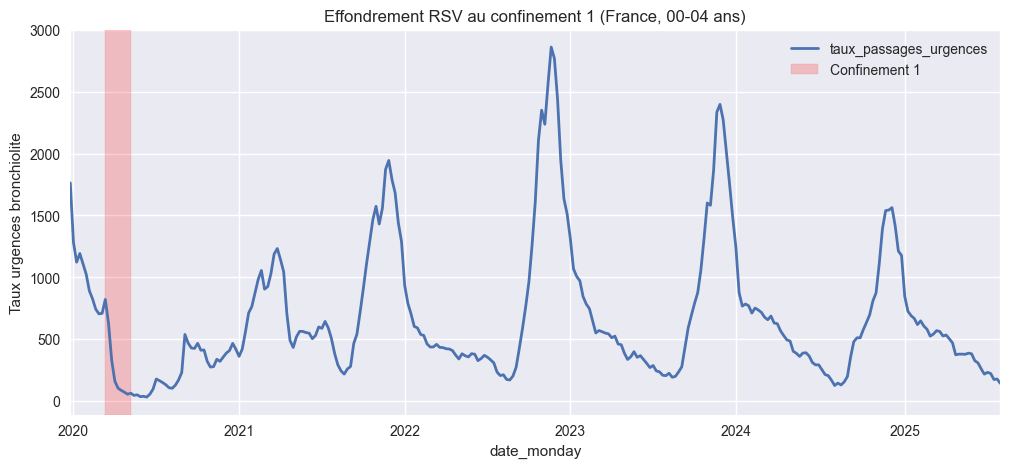

In [41]:
# %%
pre_conf = rsv_fr.loc["2020-02-17":"2020-03-15","taux_passages_urgences"].mean()
post_conf = rsv_fr.loc["2020-03-16":"2020-04-15","taux_passages_urgences"].mean()

print("------ Effondrement RSV Confinement 1 ------")
print(f"Moyenne avant confinement : {pre_conf:.1f}")
print(f"Moyenne après confinement : {post_conf:.1f}")
drop_pct = 100*(post_conf-pre_conf)/pre_conf
print(f"Variation relative : {drop_pct:.1f}%")

ax = rsv_fr["taux_passages_urgences"].plot(figsize=(12,5), lw=2,
                                           title="Effondrement RSV au confinement 1 (France, 00-04 ans)")
plt.axvspan("2020-03-16","2020-05-11",color="red",alpha=0.2,label="Confinement 1")
plt.ylabel("Taux urgences bronchiolite")
plt.legend()
plt.show()


In [42]:
# %%
baseline_peak = rsv_fr.loc["2019-11":"2020-02","taux_passages_urgences"].max()
season2021_peak = rsv_fr.loc["2020-11":"2021-06","taux_passages_urgences"].max()

baseline_peak_date = rsv_fr.loc["2019-11":"2020-02","taux_passages_urgences"].idxmax()
season2021_peak_date = rsv_fr.loc["2020-11":"2021-06","taux_passages_urgences"].idxmax()

delay_weeks = (season2021_peak_date - baseline_peak_date).days/7

print("------ Saison 2020-21 ------")
print(f"Pic baseline (2019-20) : {baseline_peak:.0f}")
print(f"Pic saison 2020-21    : {season2021_peak:.0f}")
print(f"Décalage du pic : {delay_weeks:.0f} semaines")


------ Saison 2020-21 ------
Pic baseline (2019-20) : 1763
Pic saison 2020-21    : 1233
Décalage du pic : 65 semaines


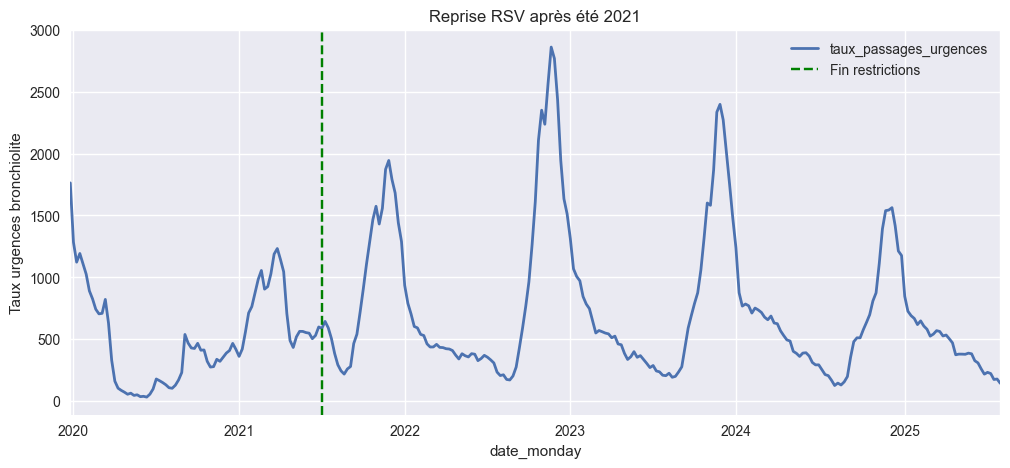

In [43]:
# %%
ax = rsv_fr["taux_passages_urgences"].plot(figsize=(12,5), lw=2,
                                           title="Reprise RSV après été 2021")
plt.axvline("2021-07-01",color="green",ls="--",label="Fin restrictions")
plt.ylabel("Taux urgences bronchiolite")
plt.legend()
plt.show()


In [44]:
# %%
# Transformation CoviPrev → semaines ISO
cov = coviprev.copy()
cov["year_iso"] = cov["date_monday"].dt.isocalendar().year.astype(int)
cov["week_iso_num"] = cov["date_monday"].dt.isocalendar().week.astype(int)

# Pivot large : 1 colonne = 1 indicateur
cov_wide = cov.pivot_table(index=["year_iso","week_iso_num"],
                           columns="indicator", values="value", aggfunc="mean").reset_index()

# Ajout colonne date_monday (lundi ISO)
cov_wide["date_monday"] = pd.to_datetime(
    cov_wide["year_iso"].astype(str) + "-W" +
    cov_wide["week_iso_num"].astype(str).str.zfill(2) + "-1",
    format="%G-W%V-%u"
)

cov_wide = cov_wide.set_index("date_monday").sort_index()
print("Shape CoviPrev weekly:", cov_wide.shape)
print("Colonnes:", cov_wide.columns.tolist())

# On garde seulement les colonnes d'intérêt (indicateurs)
cov_wide = cov_wide.drop(columns=["year_iso","week_iso_num"], errors="ignore")

# Fusion RSV + CoviPrev
df = rsv_fr.join(cov_wide, how="left").sort_index()

print(df.head())



Shape CoviPrev weekly: (12, 11)
Colonnes: ['year_iso', 'week_iso_num', 'adhesion_vaccinale_adultes', 'adhesion_vaccinale_enfants', 'aeration_du_logement', 'eviter_les_regrupements', 'lavage_des_mains', 'port_du_masque', 'saluer_sans_serrer_la_main', 'vaccines_adultes', 'vaccines_enfants']
             year_iso  week_iso_num geo_level geo_code geo_name classe_d_age  \
date_monday                                                                    
2019-12-30       2020             1        FR       FR   France       0-1 an   
2020-01-06       2020             2        FR       FR   France       0-1 an   
2020-01-13       2020             3        FR       FR   France       0-1 an   
2020-01-20       2020             4        FR       FR   France       0-1 an   
2020-01-27       2020             5        FR       FR   France       0-1 an   

             taux_passages_urgences    taux_hosp    taux_sos topic  \
date_monday                                                          
2019-12-3

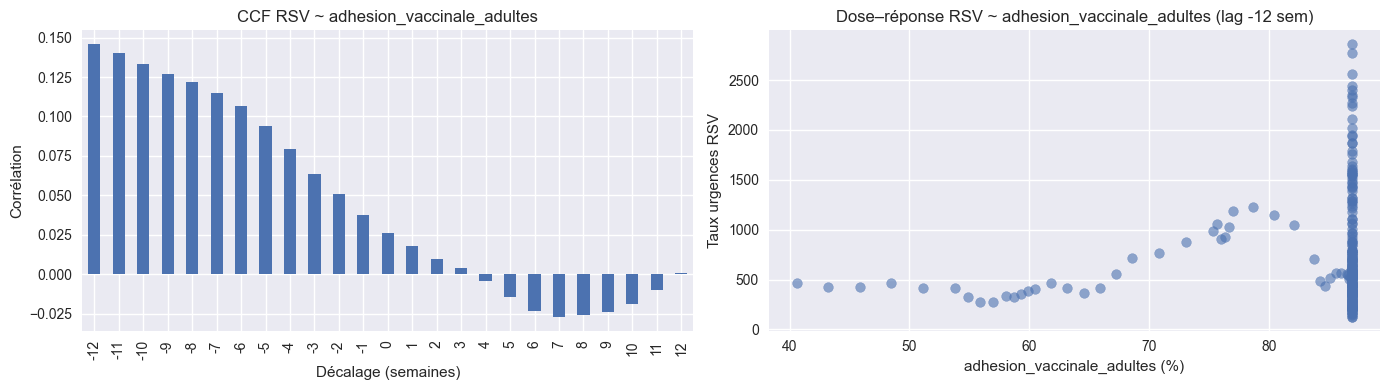

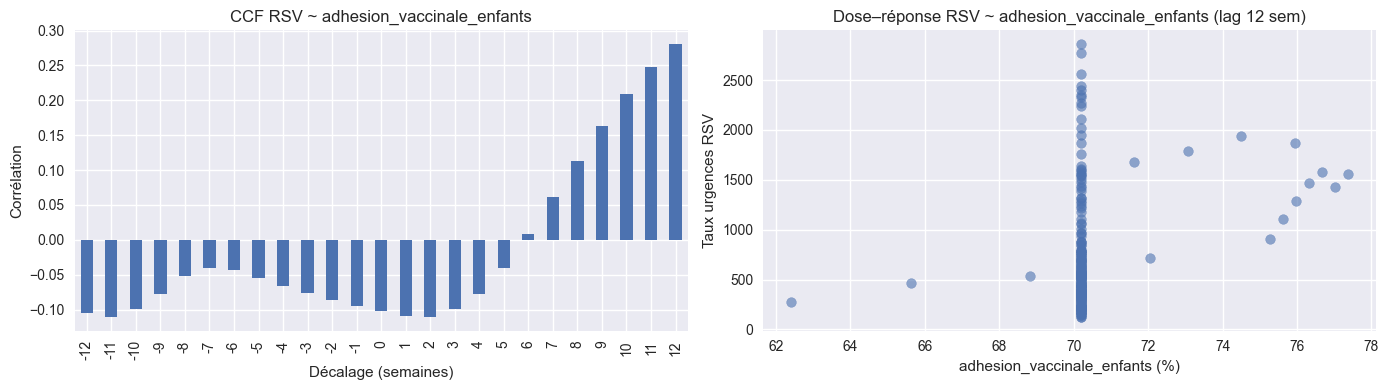

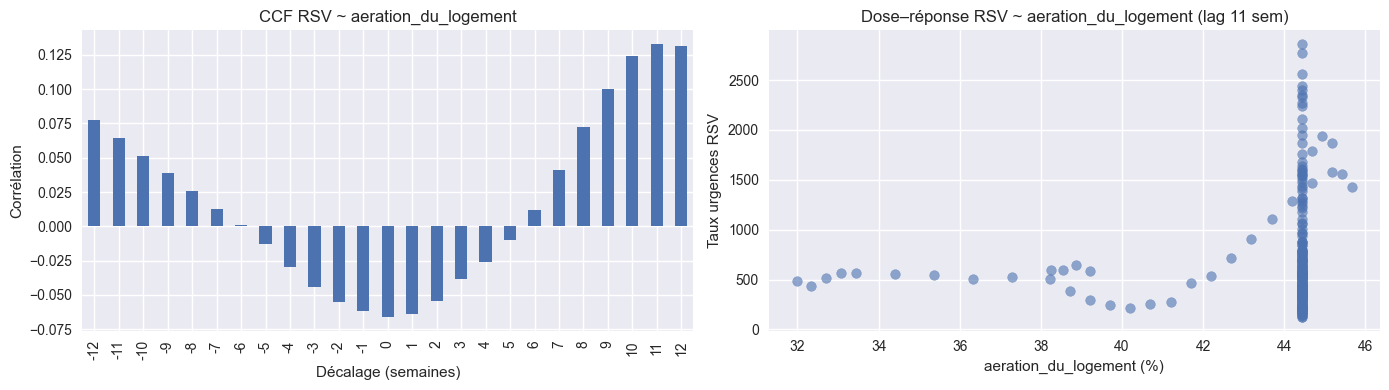

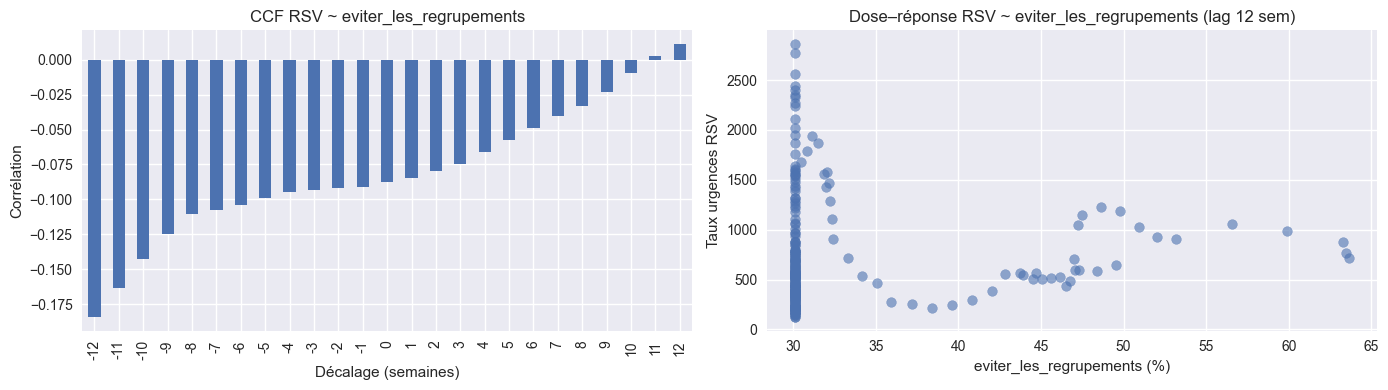

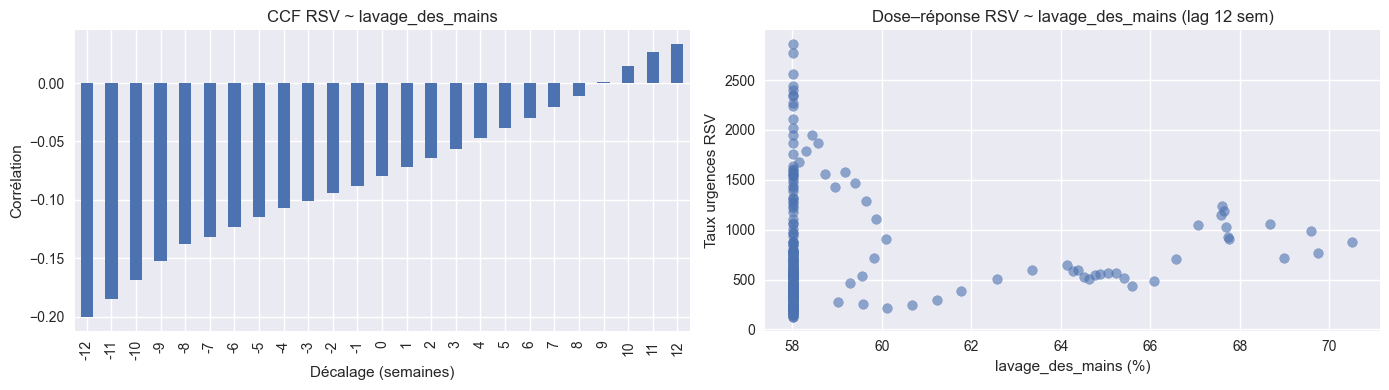

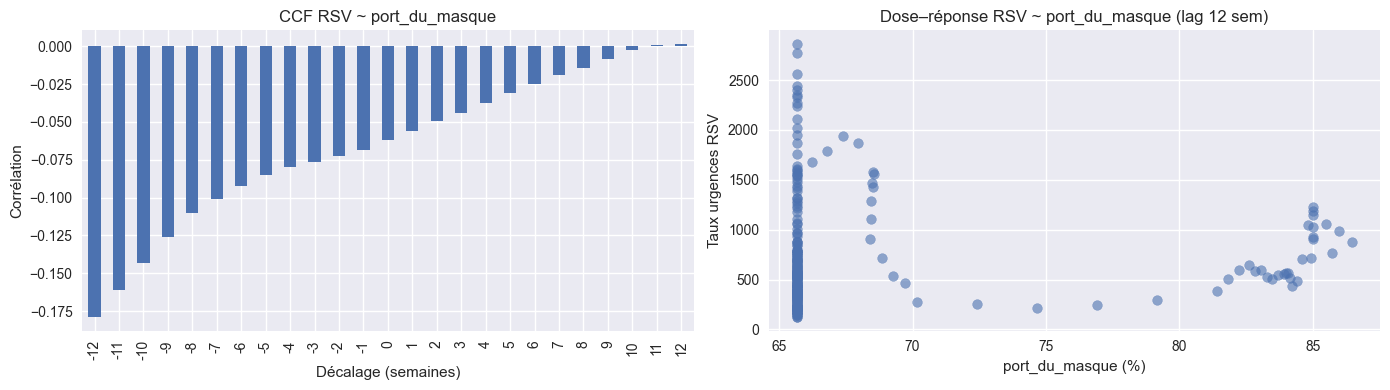

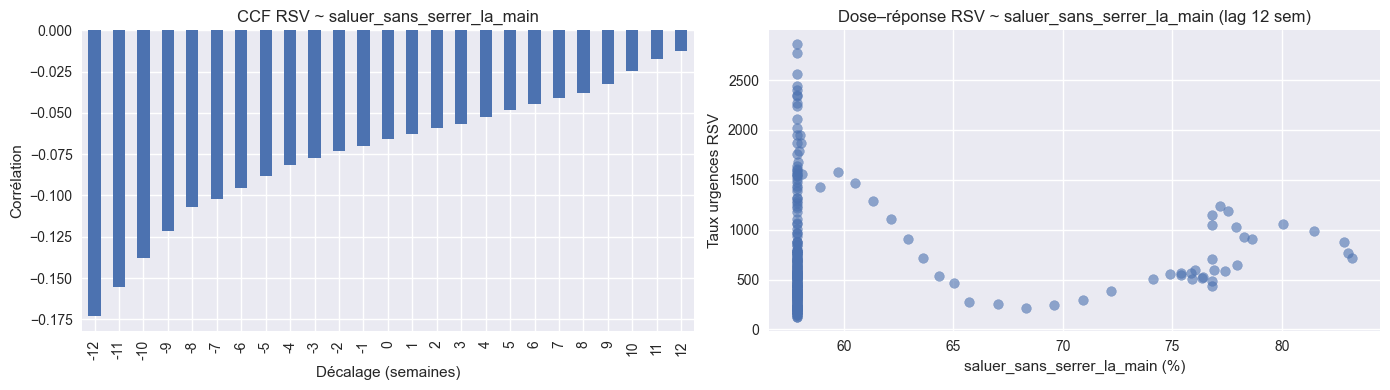

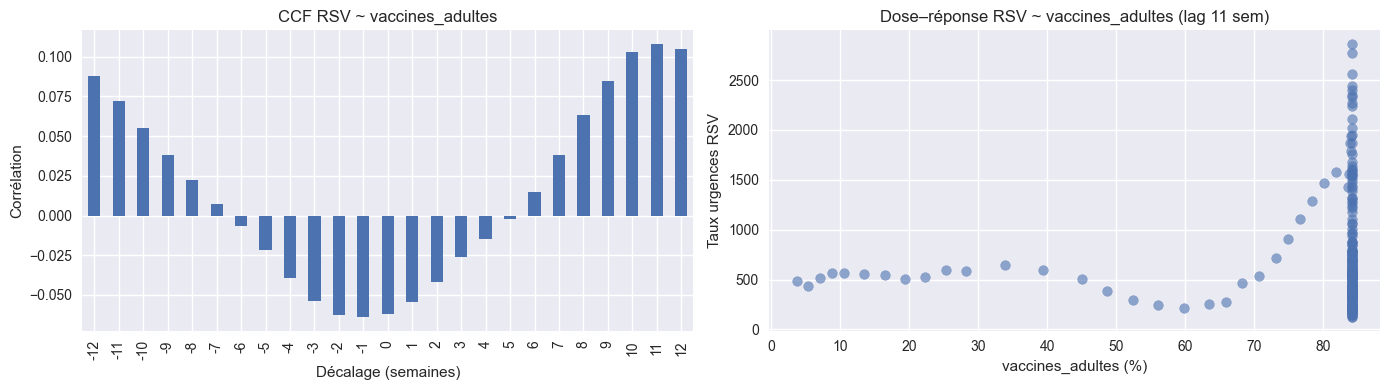

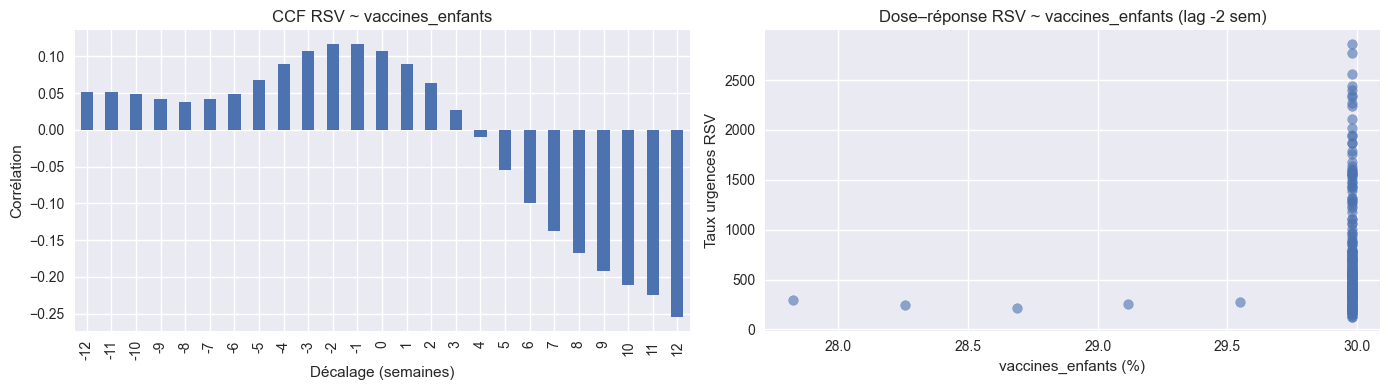

,indicator,best_lag,best_ccf,dose_response_corr
1,adhesion_vaccinale_enfants,12,0.280755,0.280755
0,adhesion_vaccinale_adultes,-12,0.145905,0.145905
2,aeration_du_logement,11,0.132985,0.132985
8,vaccines_enfants,-2,0.116684,0.116684
7,vaccines_adultes,11,0.108017,0.108017
4,lavage_des_mains,12,0.033397,0.033397
3,eviter_les_regrupements,12,0.011235,0.011235
5,port_du_masque,12,0.001383,0.001383
6,saluer_sans_serrer_la_main,12,-0.012280,-0.012280


In [45]:
# %%
results = []

for ind in cov_wide.columns.drop(["year_iso","week_iso_num"], errors="ignore"):
    x = df[ind].interpolate().ffill()  # interpolation + ffill
    y = df["taux_passages_urgences"]

    # Corrélations croisées
    lags = range(-12, 13)
    vals = {}
    for l in lags:
        shifted = x.shift(l)
        if shifted.notna().sum() > 5:
            vals[l] = y.corr(shifted)
    if not vals:
        results.append((ind, np.nan, np.nan, np.nan))
        continue

    best_lag = max(vals, key=lambda lag: abs(vals[lag]))
    best_corr = vals[best_lag]

    # Corrélation dose–réponse au lag optimal
    X = x.shift(best_lag)
    valid_idx = X.dropna().index.intersection(y.dropna().index)
    if len(valid_idx) > 5:
        corr = np.corrcoef(X.loc[valid_idx], y.loc[valid_idx])[0,1]
    else:
        corr = np.nan

    results.append((ind, best_lag, best_corr, corr))

    # Figures
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    # CCF barplot
    pd.Series(vals).plot(kind="bar", ax=axes[0], title=f"CCF RSV ~ {ind}")
    axes[0].set_xlabel("Décalage (semaines)")
    axes[0].set_ylabel("Corrélation")

    # Scatter dose–réponse
    axes[1].scatter(X.loc[valid_idx], y.loc[valid_idx], alpha=0.6)
    axes[1].set_title(f"Dose–réponse RSV ~ {ind} (lag {best_lag} sem)")
    axes[1].set_xlabel(f"{ind} (%)")
    axes[1].set_ylabel("Taux urgences RSV")

    plt.tight_layout()
    plt.show()

summary = pd.DataFrame(results, columns=["indicator","best_lag","best_ccf","dose_response_corr"])
display(summary.sort_values("best_ccf", ascending=False))


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/384351084.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




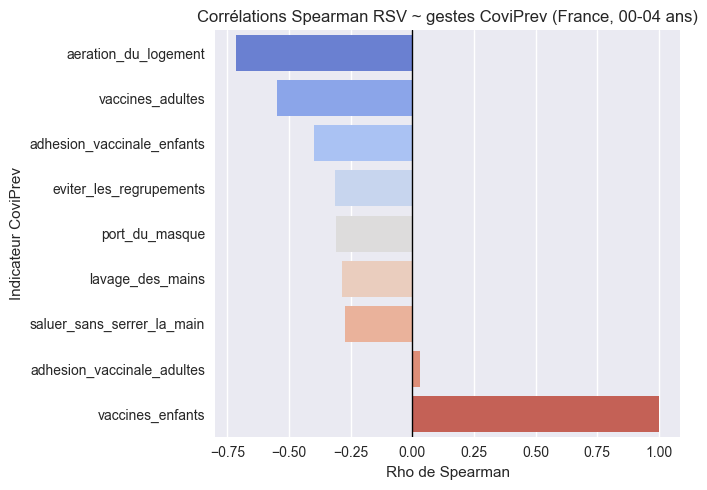

,indicator,rho,pval
2,aeration_du_logement,-0.714286,0.110787
7,vaccines_adultes,-0.547619,0.160026
1,adhesion_vaccinale_enfants,-0.400000,0.600000
3,eviter_les_regrupements,-0.314685,0.319139
5,port_du_masque,-0.307692,0.330589
4,lavage_des_mains,-0.286713,0.366251
6,saluer_sans_serrer_la_main,-0.272727,0.391097
0,adhesion_vaccinale_adultes,0.030303,0.933773
8,vaccines_enfants,1.000000,NaN


In [46]:
# %%
results = []

# On parcourt seulement les colonnes des indicateurs CoviPrev
for col in cov_wide.columns:
    if col not in df.columns:
        continue
    rho, p = spearmanr(df[col], df["taux_passages_urgences"], nan_policy="omit")
    results.append((col, rho, p))

# Tableau récapitulatif
corrs = pd.DataFrame(results, columns=["indicator","rho","pval"]).sort_values("rho")

# Viz barplot
plt.figure(figsize=(7,5))
sns.barplot(data=corrs, x="rho", y="indicator", hue="indicator",
            palette="coolwarm", dodge=False, legend=False)
plt.axvline(0, color="k", lw=1)
plt.title("Corrélations Spearman RSV ~ gestes CoviPrev (France, 00-04 ans)")
plt.xlabel("Rho de Spearman")
plt.ylabel("Indicateur CoviPrev")
plt.tight_layout()
plt.show()

display(corrs)


In [47]:
# %%
season1920 = rsv_fr.loc["2019-09":"2020-05","taux_passages_urgences"].sum()
season2122 = rsv_fr.loc["2021-09":"2022-05","taux_passages_urgences"].sum()

print("------ Comparaison saisons ------")
print(f"Nombre cumulé RSV 2019-20 : {season1920:.0f}")
print(f"Nombre cumulé RSV 2021-22 : {season2122:.0f}")
print(f"Amplification relative : {100*(season2122/season1920-1):.0f}%")


------ Comparaison saisons ------
Nombre cumulé RSV 2019-20 : 13784
Nombre cumulé RSV 2021-22 : 32153
Amplification relative : 133%


/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_36957/952595184.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




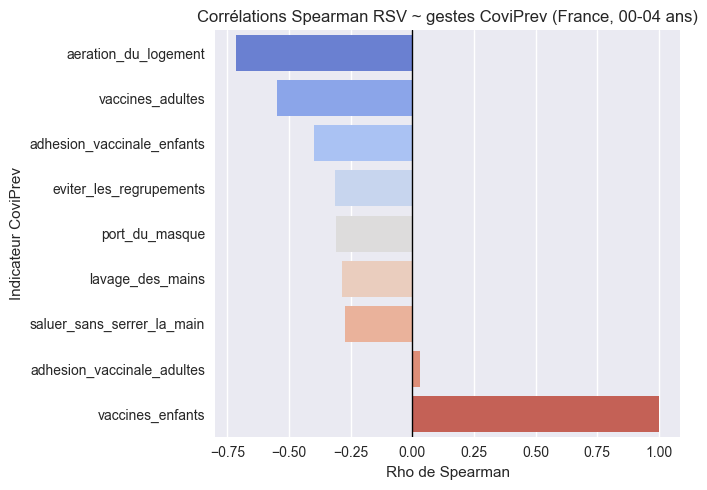

,indicator,best_lag,best_ccf,dose_response_corr,rho,pval
1,adhesion_vaccinale_enfants,12,0.280755,0.280755,-0.400000,0.600000
0,adhesion_vaccinale_adultes,-12,0.145905,0.145905,0.030303,0.933773
2,aeration_du_logement,11,0.132985,0.132985,-0.714286,0.110787
8,vaccines_enfants,-2,0.116684,0.116684,1.000000,NaN
7,vaccines_adultes,11,0.108017,0.108017,-0.547619,0.160026
4,lavage_des_mains,12,0.033397,0.033397,-0.286713,0.366251
3,eviter_les_regrupements,12,0.011235,0.011235,-0.314685,0.319139
5,port_du_masque,12,0.001383,0.001383,-0.307692,0.330589
6,saluer_sans_serrer_la_main,12,-0.012280,-0.012280,-0.272727,0.391097


In [48]:
# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

OUTDIR = Path("../outputs/IV1_results")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ============================
# Fusion RSV + CoviPrev weekly
# ============================
cov = coviprev.copy()
cov["year_iso"] = cov["date_monday"].dt.isocalendar().year.astype(int)
cov["week_iso_num"] = cov["date_monday"].dt.isocalendar().week.astype(int)

cov_wide = cov.pivot_table(index=["year_iso","week_iso_num"],
                           columns="indicator", values="value", aggfunc="mean").reset_index()

cov_wide["date_monday"] = pd.to_datetime(
    cov_wide["year_iso"].astype(str) + "-W" +
    cov_wide["week_iso_num"].astype(str).str.zfill(2) + "-1",
    format="%G-W%V-%u"
)

cov_wide = cov_wide.set_index("date_monday").sort_index()
cov_wide = cov_wide.drop(columns=["year_iso","week_iso_num"], errors="ignore")

df = rsv_fr.join(cov_wide, how="left").sort_index()

# ============================
# 1. Corrélations Spearman brutes
# ============================
results = []
for col in cov_wide.columns:
    rho, p = spearmanr(df[col], df["taux_passages_urgences"], nan_policy="omit")
    results.append((col, rho, p))

corrs = pd.DataFrame(results, columns=["indicator","rho","pval"]).sort_values("rho")

# Barplot global
plt.figure(figsize=(7,5))
sns.barplot(data=corrs, x="rho", y="indicator", hue="indicator",
            palette="coolwarm", dodge=False, legend=False)
plt.axvline(0, color="k", lw=1)
plt.title("Corrélations Spearman RSV ~ gestes CoviPrev (France, 00-04 ans)")
plt.xlabel("Rho de Spearman")
plt.ylabel("Indicateur CoviPrev")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_coviprev_spearman.png", dpi=300)
plt.show()

# ============================
# 2. Corrélations croisées (CCF) + scatter dose–réponse
# ============================
results_ccf = []

for ind in cov_wide.columns:
    x = df[ind].interpolate().ffill()
    y = df["taux_passages_urgences"]

    lags = range(-12, 13)
    vals = {}
    for l in lags:
        shifted = x.shift(l)
        if shifted.notna().sum() > 5:
            vals[l] = y.corr(shifted)

    if not vals:
        results_ccf.append((ind, np.nan, np.nan, np.nan))
        continue

    best_lag = max(vals, key=lambda lag: abs(vals[lag]))
    best_corr = vals[best_lag]

    X = x.shift(best_lag)
    valid_idx = X.dropna().index.intersection(y.dropna().index)
    if len(valid_idx) > 5:
        corr_lag = np.corrcoef(X.loc[valid_idx], y.loc[valid_idx])[0,1]
    else:
        corr_lag = np.nan

    results_ccf.append((ind, best_lag, best_corr, corr_lag))

    # --- Figures ---
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    # CCF
    pd.Series(vals).plot(kind="bar", ax=axes[0], title=f"CCF RSV ~ {ind}")
    axes[0].set_xlabel("Décalage (semaines)")
    axes[0].set_ylabel("Corrélation")

    # Scatter dose–réponse
    axes[1].scatter(X.loc[valid_idx], y.loc[valid_idx], alpha=0.6)
    axes[1].set_title(f"Dose–réponse RSV ~ {ind} (lag {best_lag} sem)")
    axes[1].set_xlabel(f"{ind} (%)")
    axes[1].set_ylabel("Taux urgences RSV")

    plt.tight_layout()
    plt.savefig(OUTDIR/f"fig_coviprev_{ind}.png", dpi=300)
    plt.close()

# ============================
# 3. Sauvegarde tableau summary
# ============================
summary = pd.DataFrame(results_ccf,
                       columns=["indicator","best_lag","best_ccf","dose_response_corr"])

# Merge avec rho Spearman
summary = summary.merge(corrs, on="indicator", how="left")

summary.to_csv(OUTDIR/"summary_coviprev.csv", index=False)
display(summary.sort_values("best_ccf", ascending=False))


In [49]:
# ============================
# Recalcul Score MNP étendu (2020-2025)
# ============================
import numpy as np
import pandas as pd

# 1) Masque (CoviPrev)
cov = coviprev.copy()
cov["year_iso"] = cov["date_monday"].dt.isocalendar().year.astype(int)
cov["week_iso_num"] = cov["date_monday"].dt.isocalendar().week.astype(int)

mask_iso = (cov[cov["indicator"].str.contains("masq", case=False, na=False)]
              .groupby(["year_iso","week_iso_num"], as_index=False)["value"].mean()
              .rename(columns={"value":"masque"}))

# 2) Workplaces (Google Mobility)
mob = pd.read_csv(FILES["common_FR_long"].parent.parent/"GOOGLE/google_mobility_fr_weekly.csv")
mob["date_monday"] = pd.to_datetime(mob["date_monday"], errors="coerce")
mob["year_iso"] = mob["date_monday"].dt.isocalendar().year.astype(int)
mob["week_iso_num"] = mob["date_monday"].dt.isocalendar().week.astype(int)

work_iso = (mob[mob["indicator"].str.contains("workplace", case=False, na=False)]
              .groupby(["year_iso","week_iso_num"], as_index=False)["value"].mean()
              .rename(columns={"value":"workplaces_percent_change"}))

# 3) Fusion masque + workplaces
mnp_iso = pd.merge(mask_iso, work_iso, on=["year_iso","week_iso_num"], how="inner")

# 4) Normalisation robuste (min-max 1–99%)
def minmax_robust(s, p_lo=1, p_hi=99):
    lo, hi = np.nanpercentile(s, p_lo), np.nanpercentile(s, p_hi)
    return (s.clip(lo, hi) - lo) / (hi - lo)

mnp_iso["masque_n"]   = minmax_robust(mnp_iso["masque"])
mnp_iso["work_red_n"] = minmax_robust(-mnp_iso["workplaces_percent_change"])  # inversion: ↓work = ↑MNP
mnp_iso["MNP_score"]  = mnp_iso[["masque_n","work_red_n"]].mean(axis=1)

# 5) Ajout de la vraie date_monday (ISO → lundi)
mnp_iso["date_monday"] = pd.to_datetime(
    mnp_iso["year_iso"].astype(str) + "-W" + mnp_iso["week_iso_num"].astype(str).str.zfill(2) + "-1",
    format="%G-W%V-%u"
)

mnp_iso = mnp_iso.set_index("date_monday").sort_index()

print("MNP étendu :", mnp_iso.index.min(), "→", mnp_iso.index.max(), "n=", len(mnp_iso))
display(mnp_iso)


MNP étendu : 2020-11-02 00:00:00 → 2021-09-27 00:00:00 n= 12


,year_iso,week_iso_num,masque,workplaces_percent_change,masque_n,work_red_n,MNP_score
date_monday,,,,,,,
2020-11-02,2020,45,84.937605,-28.527473,0.932024,0.838513,0.885269
2020-11-16,2020,47,86.483989,-27.384615,1.000000,0.792522,0.896261
2020-12-07,2020,50,85.004720,-20.241758,0.935319,0.505077,0.720198
2021-01-11,2021,2,85.011560,-22.472527,0.935655,0.594848,0.765252
2021-02-08,2021,6,84.214544,-25.065934,0.896521,0.699213,0.797867
2021-03-08,2021,10,83.928943,-19.230769,0.882498,0.464392,0.673445
2021-04-19,2021,16,82.618051,-31.043956,0.818132,0.939782,0.878957
2021-05-10,2021,19,81.428160,-32.725275,0.759707,1.000000,0.879854
2021-06-14,2021,24,70.155722,-7.857143,0.206220,0.006691,0.106456
